In [1]:
#=======================================
## DNN_multi cla_Iris (Cross validation)
#=======================================

# Need compile Create_DNN_model.

#----------------------------------------
# Change the current working directory to the specified path.

import os

os.getcwd()


'C:\\Users\\jghsieh\\Desktop\\Li-Chun-Ying\\Keras-Objects\\tree-like-nn\\Classification\\Iris'

In [2]:
#----------------------------------------
# Set random seed for reproducibility.

seed = 543
from numpy import random
random.seed(seed)
from tensorflow import set_random_seed
set_random_seed(seed)

# Import classes and functions.

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, concatenate, Dropout
#from keras.layers import add, subtract, multiply, average, maximum, Lambda, dot


C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#----------------------------------------
# Load the iris dataset.

dataset = np.loadtxt("IRIS-Training-Data.txt")

print(type(dataset))

print(dataset.shape)

x_group = [[2], [3]]

X = dataset[:, 0:4]
Y = dataset[:, 4]

print(X.shape)
print(Y.shape)

X1 = dataset[:, x_group[0]]
X2 = dataset[:, x_group[1]]

print(X1.shape, X2.shape)
print(Y.shape)

Y = np.array(Y, dtype = int)

print(np.unique(Y))


<class 'numpy.ndarray'>
(150, 5)
(150, 4)
(150,)
(150, 1) (150, 1)
(150,)
[1 2 3]


In [4]:
#----------------------------------------
# one-hot encoding of output variable.

Y_train = np.zeros((len(Y), 3), dtype = int)

for i in range(len(Y)):
	Y_train[i, Y[i] - 1] = 1

np.unique(Y_train)


array([0, 1])

In [5]:
#----------------------------------------
# Standardize the input and output data.

X_sample_mean = np.mean(X, axis = 0)
print(np.round(X_sample_mean, 4))

X_sample_std = np.std(X, axis = 0, ddof = 1)
print(np.round(X_sample_std, 4))

X1_sample_mean = X_sample_mean[x_group[0]]
print(np.round(X1_sample_mean, 4))

X1_sample_std = X_sample_std[x_group[0]]
print(np.round(X1_sample_std, 4))

X2_sample_mean = X_sample_mean[x_group[1]]
print(np.round(X2_sample_mean, 4))

X2_sample_std = X_sample_std[x_group[1]]
print(np.round(X2_sample_std, 4))

standardize = lambda x: (x - np.mean(x, axis = 0)) / np.std(x, axis = 0, ddof = 1)

X_train = standardize(X)

X1_train = X_train[:, x_group[0]]
X2_train = X_train[:, x_group[1]]

print(np.round(np.mean(X1_train, axis = 0), 4))
print(np.round(np.std(X1_train, axis = 0, ddof = 1), 4))

print(np.round(np.mean(X2_train, axis = 0), 4))
print(np.round(np.std(X2_train, axis = 0, ddof = 1), 4))


[5.8433 3.0573 3.758  1.1993]
[0.8281 0.4359 1.7653 0.7622]
[3.758]
[1.7653]
[1.1993]
[0.7622]
[-0.]
[1.]
[-0.]
[1.]


In [6]:
#----------------------------------------
# Define 10-fold cross validation test index sets.

fold_num = 10

L = len(X_train)

quotient = L // fold_num
remainder = L % fold_num

fold_length = np.array([quotient]*fold_num)
if remainder > 0:
    fold_length[0:remainder] = fold_length[0:remainder] + 1

index_begin = np.zeros(fold_num, dtype = int)
index_begin[0] = 0

for j in range(1, fold_num):
    index_begin[j] = index_begin[j-1] + fold_length[j-1]

index = np.random.choice(np.arange(L), size = L, replace = False)


In [7]:
#----------------------------------------
# 10-fold cross validation

cv_cc = []
cv_acc = []

for k in range(fold_num):
    # Build the tree like nn model
    input_g1 = Input(shape = (1,))
    x1 = input_g1
    t1 = Dense(units = 2, kernel_initializer = "uniform", activation = "relu")(x1)
    t1 = Dropout(rate = 0.1)(t1)
    #
    y11 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    y12 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t1)
    #
    input_g3 = Input(shape = (1,))
    x3 = concatenate([y12, input_g3], axis = 1)  # column bind
    t3 = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x3)
    t3 = Dropout(rate = 0.1)(t3)
    #
    y31 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    y32 = Dense(units = 1, kernel_initializer = "uniform", activation = "linear")(t3)
    #
    x_final =  concatenate([y11, y31, y32], axis = 1)  # column bind
    y_final = Dense(units = 3, kernel_initializer = "uniform", activation = "relu")(x_final)
    y_final = Dropout(rate = 0.1)(y_final)
    y_final = Dense(units = 3, kernel_initializer = "uniform", activation = "softmax")(y_final)
    response = y_final
    #
    model = Model(inputs = [input_g1, input_g3], outputs = response)
    #
    #model.summary()
    # Compile the model.
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    # Select index sets.
    seq_index = range(index_begin[k], (index_begin[k] + fold_length[k]))
    test_index = index[seq_index]
    train_index = np.delete(index, seq_index)
    # Fit the model.
    history = model.fit([X1_train[train_index], X2_train[train_index]]
                        , Y_train[train_index], validation_split = 0.2, epochs = 1000, batch_size = 20, verbose = 2)
    # Evaluate the model.
    scores = model.evaluate([X1_train[test_index], X2_train[test_index]]
                            , Y_train[test_index], verbose = 0)
    print("%s: %.4f" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f" % (model.metrics_names[1], scores[1]))
    cv_cc.append(scores[0])
    cv_acc.append(scores[1])


Train on 108 samples, validate on 27 samples
Epoch 1/1000
 - 1s - loss: 1.0988 - acc: 0.3241 - val_loss: 1.0985 - val_acc: 0.3704
Epoch 2/1000
 - 0s - loss: 1.0988 - acc: 0.2593 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/1000
 - 0s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/1000
 - 0s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/1000
 - 0s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/1000
 - 0s - loss: 1.0986 - acc: 0.3333 - val_loss: 1.0987 - val_acc: 0.3333
Epoch 7/1000
 - 0s - loss: 1.0986 - acc: 0.2500 - val_loss: 1.0987 - val_acc: 0.2963
Epoch 8/1000
 - 0s - loss: 1.0986 - acc: 0.3426 - val_loss: 1.0987 - val_acc: 0.2963
Epoch 9/1000
 - 0s - loss: 1.0985 - acc: 0.3426 - val_loss: 1.0987 - val_acc: 0.2963
Epoch 10/1000
 - 0s - loss: 1.0985 - acc: 0.3426 - val_loss: 1.0986 - val_acc: 0.2963
Epoch 11/1000
 - 0s - loss: 1.0984 - acc: 0.3426 - val_loss: 1.0985 - val_acc: 0.2963
Epoch 12/1000
 - 0

Epoch 96/1000
 - 0s - loss: 0.5772 - acc: 0.6574 - val_loss: 0.4869 - val_acc: 0.6667
Epoch 97/1000
 - 0s - loss: 0.5311 - acc: 0.6667 - val_loss: 0.4847 - val_acc: 0.6667
Epoch 98/1000
 - 0s - loss: 0.5662 - acc: 0.6574 - val_loss: 0.4823 - val_acc: 0.6667
Epoch 99/1000
 - 0s - loss: 0.5542 - acc: 0.6759 - val_loss: 0.4801 - val_acc: 0.6667
Epoch 100/1000
 - 0s - loss: 0.5449 - acc: 0.6389 - val_loss: 0.4781 - val_acc: 0.6667
Epoch 101/1000
 - 0s - loss: 0.5616 - acc: 0.6759 - val_loss: 0.4760 - val_acc: 0.6667
Epoch 102/1000
 - 0s - loss: 0.5534 - acc: 0.6852 - val_loss: 0.4743 - val_acc: 0.6667
Epoch 103/1000
 - 0s - loss: 0.5624 - acc: 0.6667 - val_loss: 0.4728 - val_acc: 0.6667
Epoch 104/1000
 - 0s - loss: 0.5899 - acc: 0.5833 - val_loss: 0.4713 - val_acc: 0.6667
Epoch 105/1000
 - 0s - loss: 0.5381 - acc: 0.6481 - val_loss: 0.4698 - val_acc: 0.6667
Epoch 106/1000
 - 0s - loss: 0.5606 - acc: 0.6481 - val_loss: 0.4683 - val_acc: 0.6667
Epoch 107/1000
 - 0s - loss: 0.5267 - acc: 0.69

Epoch 191/1000
 - 0s - loss: 0.4504 - acc: 0.7130 - val_loss: 0.4081 - val_acc: 0.7407
Epoch 192/1000
 - 0s - loss: 0.4899 - acc: 0.6389 - val_loss: 0.4075 - val_acc: 0.7407
Epoch 193/1000
 - 0s - loss: 0.4694 - acc: 0.6759 - val_loss: 0.4070 - val_acc: 0.7407
Epoch 194/1000
 - 0s - loss: 0.4851 - acc: 0.6667 - val_loss: 0.4065 - val_acc: 0.7407
Epoch 195/1000
 - 0s - loss: 0.4799 - acc: 0.6667 - val_loss: 0.4060 - val_acc: 0.7407
Epoch 196/1000
 - 0s - loss: 0.4829 - acc: 0.6389 - val_loss: 0.4054 - val_acc: 0.7407
Epoch 197/1000
 - 0s - loss: 0.4716 - acc: 0.6667 - val_loss: 0.4049 - val_acc: 0.7407
Epoch 198/1000
 - 0s - loss: 0.4683 - acc: 0.6574 - val_loss: 0.4043 - val_acc: 0.7407
Epoch 199/1000
 - 0s - loss: 0.4807 - acc: 0.6759 - val_loss: 0.4038 - val_acc: 0.7407
Epoch 200/1000
 - 0s - loss: 0.4708 - acc: 0.6852 - val_loss: 0.4034 - val_acc: 0.7407
Epoch 201/1000
 - 0s - loss: 0.4556 - acc: 0.7222 - val_loss: 0.4029 - val_acc: 0.7407
Epoch 202/1000
 - 0s - loss: 0.4792 - acc: 

 - 0s - loss: 0.4067 - acc: 0.7685 - val_loss: 0.3571 - val_acc: 0.8148
Epoch 286/1000
 - 0s - loss: 0.5117 - acc: 0.6574 - val_loss: 0.3565 - val_acc: 0.8148
Epoch 287/1000
 - 0s - loss: 0.4609 - acc: 0.7222 - val_loss: 0.3558 - val_acc: 0.8148
Epoch 288/1000
 - 0s - loss: 0.4067 - acc: 0.7593 - val_loss: 0.3553 - val_acc: 0.8148
Epoch 289/1000
 - 0s - loss: 0.4755 - acc: 0.7407 - val_loss: 0.3547 - val_acc: 0.8148
Epoch 290/1000
 - 0s - loss: 0.4586 - acc: 0.7500 - val_loss: 0.3541 - val_acc: 0.8519
Epoch 291/1000
 - 0s - loss: 0.4408 - acc: 0.7778 - val_loss: 0.3533 - val_acc: 0.8519
Epoch 292/1000
 - 0s - loss: 0.4171 - acc: 0.7963 - val_loss: 0.3526 - val_acc: 0.8519
Epoch 293/1000
 - 0s - loss: 0.4518 - acc: 0.7685 - val_loss: 0.3517 - val_acc: 0.8148
Epoch 294/1000
 - 0s - loss: 0.3996 - acc: 0.7963 - val_loss: 0.3512 - val_acc: 0.8148
Epoch 295/1000
 - 0s - loss: 0.4506 - acc: 0.7130 - val_loss: 0.3509 - val_acc: 0.8148
Epoch 296/1000
 - 0s - loss: 0.3863 - acc: 0.7963 - val_lo

Epoch 380/1000
 - 0s - loss: 0.4543 - acc: 0.7870 - val_loss: 0.3158 - val_acc: 0.8889
Epoch 381/1000
 - 0s - loss: 0.3634 - acc: 0.8241 - val_loss: 0.3152 - val_acc: 0.8889
Epoch 382/1000
 - 0s - loss: 0.4008 - acc: 0.7963 - val_loss: 0.3146 - val_acc: 0.8889
Epoch 383/1000
 - 0s - loss: 0.4123 - acc: 0.7870 - val_loss: 0.3141 - val_acc: 0.8889
Epoch 384/1000
 - 0s - loss: 0.3486 - acc: 0.8426 - val_loss: 0.3135 - val_acc: 0.8889
Epoch 385/1000
 - 0s - loss: 0.3602 - acc: 0.8333 - val_loss: 0.3128 - val_acc: 0.8889
Epoch 386/1000
 - 0s - loss: 0.4157 - acc: 0.7870 - val_loss: 0.3122 - val_acc: 0.8889
Epoch 387/1000
 - 0s - loss: 0.4703 - acc: 0.7500 - val_loss: 0.3117 - val_acc: 0.8889
Epoch 388/1000
 - 0s - loss: 0.4109 - acc: 0.7963 - val_loss: 0.3112 - val_acc: 0.8889
Epoch 389/1000
 - 0s - loss: 0.4136 - acc: 0.7870 - val_loss: 0.3108 - val_acc: 0.8889
Epoch 390/1000
 - 0s - loss: 0.4348 - acc: 0.8056 - val_loss: 0.3104 - val_acc: 0.8889
Epoch 391/1000
 - 0s - loss: 0.4016 - acc: 

 - 0s - loss: 0.4231 - acc: 0.8148 - val_loss: 0.2755 - val_acc: 0.9259
Epoch 475/1000
 - 0s - loss: 0.4590 - acc: 0.7963 - val_loss: 0.2753 - val_acc: 0.9259
Epoch 476/1000
 - 0s - loss: 0.4585 - acc: 0.8056 - val_loss: 0.2753 - val_acc: 0.9259
Epoch 477/1000
 - 0s - loss: 0.4576 - acc: 0.7870 - val_loss: 0.2753 - val_acc: 0.9259
Epoch 478/1000
 - 0s - loss: 0.3239 - acc: 0.8889 - val_loss: 0.2752 - val_acc: 0.9630
Epoch 479/1000
 - 0s - loss: 0.3761 - acc: 0.8519 - val_loss: 0.2746 - val_acc: 0.9259
Epoch 480/1000
 - 0s - loss: 0.4201 - acc: 0.8241 - val_loss: 0.2739 - val_acc: 0.9259
Epoch 481/1000
 - 0s - loss: 0.3828 - acc: 0.8704 - val_loss: 0.2732 - val_acc: 0.9259
Epoch 482/1000
 - 0s - loss: 0.3333 - acc: 0.8796 - val_loss: 0.2722 - val_acc: 0.9259
Epoch 483/1000
 - 0s - loss: 0.4372 - acc: 0.8148 - val_loss: 0.2714 - val_acc: 0.9259
Epoch 484/1000
 - 0s - loss: 0.3224 - acc: 0.8796 - val_loss: 0.2709 - val_acc: 0.9259
Epoch 485/1000
 - 0s - loss: 0.3332 - acc: 0.8796 - val_lo

Epoch 569/1000
 - 0s - loss: 0.3685 - acc: 0.8611 - val_loss: 0.2338 - val_acc: 0.9259
Epoch 570/1000
 - 0s - loss: 0.2952 - acc: 0.8981 - val_loss: 0.2334 - val_acc: 0.9259
Epoch 571/1000
 - 0s - loss: 0.3667 - acc: 0.8519 - val_loss: 0.2330 - val_acc: 0.9259
Epoch 572/1000
 - 0s - loss: 0.3272 - acc: 0.9074 - val_loss: 0.2326 - val_acc: 0.9259
Epoch 573/1000
 - 0s - loss: 0.3231 - acc: 0.8704 - val_loss: 0.2321 - val_acc: 0.9259
Epoch 574/1000
 - 0s - loss: 0.3029 - acc: 0.8796 - val_loss: 0.2316 - val_acc: 0.9259
Epoch 575/1000
 - 0s - loss: 0.2767 - acc: 0.8981 - val_loss: 0.2311 - val_acc: 0.9259
Epoch 576/1000
 - 0s - loss: 0.3461 - acc: 0.8889 - val_loss: 0.2304 - val_acc: 0.9630
Epoch 577/1000
 - 0s - loss: 0.4264 - acc: 0.8056 - val_loss: 0.2301 - val_acc: 0.9630
Epoch 578/1000
 - 0s - loss: 0.3664 - acc: 0.8426 - val_loss: 0.2299 - val_acc: 0.9630
Epoch 579/1000
 - 0s - loss: 0.3345 - acc: 0.8796 - val_loss: 0.2296 - val_acc: 0.9630
Epoch 580/1000
 - 0s - loss: 0.3434 - acc: 

Epoch 664/1000
 - 0s - loss: 0.2877 - acc: 0.8889 - val_loss: 0.2008 - val_acc: 0.9630
Epoch 665/1000
 - 0s - loss: 0.3489 - acc: 0.8611 - val_loss: 0.2006 - val_acc: 0.9630
Epoch 666/1000
 - 0s - loss: 0.2724 - acc: 0.8981 - val_loss: 0.2001 - val_acc: 0.9630
Epoch 667/1000
 - 0s - loss: 0.2837 - acc: 0.8889 - val_loss: 0.1998 - val_acc: 0.9630
Epoch 668/1000
 - 0s - loss: 0.3104 - acc: 0.8704 - val_loss: 0.1994 - val_acc: 0.9630
Epoch 669/1000
 - 0s - loss: 0.3295 - acc: 0.8519 - val_loss: 0.1992 - val_acc: 0.9630
Epoch 670/1000
 - 0s - loss: 0.3073 - acc: 0.8704 - val_loss: 0.1988 - val_acc: 0.9630
Epoch 671/1000
 - 0s - loss: 0.2761 - acc: 0.8796 - val_loss: 0.1982 - val_acc: 0.9630
Epoch 672/1000
 - 0s - loss: 0.3869 - acc: 0.8333 - val_loss: 0.1979 - val_acc: 0.9630
Epoch 673/1000
 - 0s - loss: 0.3491 - acc: 0.8796 - val_loss: 0.1979 - val_acc: 0.9630
Epoch 674/1000
 - 0s - loss: 0.2991 - acc: 0.8889 - val_loss: 0.1978 - val_acc: 0.9630
Epoch 675/1000
 - 0s - loss: 0.2797 - acc: 

 - 0s - loss: 0.2840 - acc: 0.8981 - val_loss: 0.1768 - val_acc: 0.9630
Epoch 759/1000
 - 0s - loss: 0.3007 - acc: 0.9074 - val_loss: 0.1767 - val_acc: 0.9630
Epoch 760/1000
 - 0s - loss: 0.2631 - acc: 0.9259 - val_loss: 0.1764 - val_acc: 0.9630
Epoch 761/1000
 - 0s - loss: 0.2776 - acc: 0.9074 - val_loss: 0.1762 - val_acc: 0.9630
Epoch 762/1000
 - 0s - loss: 0.2376 - acc: 0.9352 - val_loss: 0.1759 - val_acc: 0.9630
Epoch 763/1000
 - 0s - loss: 0.3479 - acc: 0.8704 - val_loss: 0.1756 - val_acc: 0.9630
Epoch 764/1000
 - 0s - loss: 0.2707 - acc: 0.9167 - val_loss: 0.1755 - val_acc: 0.9630
Epoch 765/1000
 - 0s - loss: 0.3372 - acc: 0.8796 - val_loss: 0.1752 - val_acc: 0.9630
Epoch 766/1000
 - 0s - loss: 0.3366 - acc: 0.8704 - val_loss: 0.1750 - val_acc: 0.9630
Epoch 767/1000
 - 0s - loss: 0.3170 - acc: 0.8981 - val_loss: 0.1748 - val_acc: 0.9630
Epoch 768/1000
 - 0s - loss: 0.2680 - acc: 0.9074 - val_loss: 0.1746 - val_acc: 0.9630
Epoch 769/1000
 - 0s - loss: 0.3755 - acc: 0.8426 - val_lo

Epoch 853/1000
 - 0s - loss: 0.3928 - acc: 0.8426 - val_loss: 0.1598 - val_acc: 0.9630
Epoch 854/1000
 - 0s - loss: 0.3110 - acc: 0.8889 - val_loss: 0.1600 - val_acc: 0.9630
Epoch 855/1000
 - 0s - loss: 0.2715 - acc: 0.9074 - val_loss: 0.1604 - val_acc: 0.9630
Epoch 856/1000
 - 0s - loss: 0.3298 - acc: 0.8796 - val_loss: 0.1607 - val_acc: 0.9630
Epoch 857/1000
 - 0s - loss: 0.2526 - acc: 0.9074 - val_loss: 0.1610 - val_acc: 0.9630
Epoch 858/1000
 - 0s - loss: 0.2761 - acc: 0.8981 - val_loss: 0.1610 - val_acc: 0.9630
Epoch 859/1000
 - 0s - loss: 0.3350 - acc: 0.8704 - val_loss: 0.1608 - val_acc: 0.9630
Epoch 860/1000
 - 0s - loss: 0.2300 - acc: 0.9259 - val_loss: 0.1609 - val_acc: 0.9630
Epoch 861/1000
 - 0s - loss: 0.3253 - acc: 0.8796 - val_loss: 0.1612 - val_acc: 0.9630
Epoch 862/1000
 - 0s - loss: 0.3204 - acc: 0.8981 - val_loss: 0.1616 - val_acc: 0.9630
Epoch 863/1000
 - 0s - loss: 0.2727 - acc: 0.8981 - val_loss: 0.1610 - val_acc: 0.9630
Epoch 864/1000
 - 0s - loss: 0.3653 - acc: 

 - 0s - loss: 0.2580 - acc: 0.9074 - val_loss: 0.1522 - val_acc: 0.9630
Epoch 948/1000
 - 0s - loss: 0.2717 - acc: 0.9074 - val_loss: 0.1518 - val_acc: 0.9630
Epoch 949/1000
 - 0s - loss: 0.2856 - acc: 0.8796 - val_loss: 0.1513 - val_acc: 0.9630
Epoch 950/1000
 - 0s - loss: 0.2765 - acc: 0.8981 - val_loss: 0.1499 - val_acc: 0.9630
Epoch 951/1000
 - 0s - loss: 0.2754 - acc: 0.9074 - val_loss: 0.1494 - val_acc: 0.9630
Epoch 952/1000
 - 0s - loss: 0.3204 - acc: 0.8704 - val_loss: 0.1489 - val_acc: 0.9630
Epoch 953/1000
 - 0s - loss: 0.3227 - acc: 0.8796 - val_loss: 0.1486 - val_acc: 0.9630
Epoch 954/1000
 - 0s - loss: 0.3123 - acc: 0.8889 - val_loss: 0.1473 - val_acc: 0.9630
Epoch 955/1000
 - 0s - loss: 0.2587 - acc: 0.9074 - val_loss: 0.1468 - val_acc: 0.9630
Epoch 956/1000
 - 0s - loss: 0.2511 - acc: 0.9074 - val_loss: 0.1451 - val_acc: 0.9630
Epoch 957/1000
 - 0s - loss: 0.2904 - acc: 0.8889 - val_loss: 0.1451 - val_acc: 0.9630
Epoch 958/1000
 - 0s - loss: 0.2615 - acc: 0.8981 - val_lo

Epoch 42/1000
 - 0s - loss: 0.8945 - acc: 0.6574 - val_loss: 0.8817 - val_acc: 0.6667
Epoch 43/1000
 - 0s - loss: 0.8937 - acc: 0.6574 - val_loss: 0.8607 - val_acc: 0.6667
Epoch 44/1000
 - 0s - loss: 0.8724 - acc: 0.6574 - val_loss: 0.8384 - val_acc: 0.6667
Epoch 45/1000
 - 0s - loss: 0.8422 - acc: 0.6481 - val_loss: 0.8162 - val_acc: 0.6667
Epoch 46/1000
 - 0s - loss: 0.8365 - acc: 0.6481 - val_loss: 0.7942 - val_acc: 0.6667
Epoch 47/1000
 - 0s - loss: 0.8209 - acc: 0.6481 - val_loss: 0.7719 - val_acc: 0.6667
Epoch 48/1000
 - 0s - loss: 0.7999 - acc: 0.6481 - val_loss: 0.7496 - val_acc: 0.6667
Epoch 49/1000
 - 0s - loss: 0.7695 - acc: 0.6389 - val_loss: 0.7276 - val_acc: 0.6667
Epoch 50/1000
 - 0s - loss: 0.7654 - acc: 0.6204 - val_loss: 0.7056 - val_acc: 0.6667
Epoch 51/1000
 - 0s - loss: 0.7476 - acc: 0.6389 - val_loss: 0.6846 - val_acc: 0.6667
Epoch 52/1000
 - 0s - loss: 0.7111 - acc: 0.6481 - val_loss: 0.6635 - val_acc: 0.6667
Epoch 53/1000
 - 0s - loss: 0.7124 - acc: 0.6574 - val

Epoch 137/1000
 - 0s - loss: 0.4095 - acc: 0.7407 - val_loss: 0.3443 - val_acc: 0.7778
Epoch 138/1000
 - 0s - loss: 0.4386 - acc: 0.7315 - val_loss: 0.3433 - val_acc: 0.7778
Epoch 139/1000
 - 0s - loss: 0.3716 - acc: 0.8056 - val_loss: 0.3428 - val_acc: 0.7778
Epoch 140/1000
 - 0s - loss: 0.4704 - acc: 0.6759 - val_loss: 0.3426 - val_acc: 0.7407
Epoch 141/1000
 - 0s - loss: 0.4325 - acc: 0.7593 - val_loss: 0.3415 - val_acc: 0.7778
Epoch 142/1000
 - 0s - loss: 0.4168 - acc: 0.7870 - val_loss: 0.3406 - val_acc: 0.7778
Epoch 143/1000
 - 0s - loss: 0.4506 - acc: 0.7315 - val_loss: 0.3405 - val_acc: 0.7778
Epoch 144/1000
 - 0s - loss: 0.3792 - acc: 0.8241 - val_loss: 0.3405 - val_acc: 0.7407
Epoch 145/1000
 - 0s - loss: 0.4085 - acc: 0.7963 - val_loss: 0.3406 - val_acc: 0.7407
Epoch 146/1000
 - 0s - loss: 0.4170 - acc: 0.7593 - val_loss: 0.3390 - val_acc: 0.7407
Epoch 147/1000
 - 0s - loss: 0.4583 - acc: 0.7130 - val_loss: 0.3371 - val_acc: 0.7778
Epoch 148/1000
 - 0s - loss: 0.4009 - acc: 

 - 0s - loss: 0.3651 - acc: 0.8056 - val_loss: 0.2784 - val_acc: 0.8519
Epoch 232/1000
 - 0s - loss: 0.4307 - acc: 0.7593 - val_loss: 0.2771 - val_acc: 0.8889
Epoch 233/1000
 - 0s - loss: 0.4150 - acc: 0.7593 - val_loss: 0.2766 - val_acc: 0.8889
Epoch 234/1000
 - 0s - loss: 0.4094 - acc: 0.7870 - val_loss: 0.2750 - val_acc: 0.8889
Epoch 235/1000
 - 0s - loss: 0.3593 - acc: 0.8241 - val_loss: 0.2735 - val_acc: 0.8889
Epoch 236/1000
 - 0s - loss: 0.3469 - acc: 0.8148 - val_loss: 0.2735 - val_acc: 0.8889
Epoch 237/1000
 - 0s - loss: 0.3992 - acc: 0.7870 - val_loss: 0.2737 - val_acc: 0.8889
Epoch 238/1000
 - 0s - loss: 0.3441 - acc: 0.8519 - val_loss: 0.2721 - val_acc: 0.8889
Epoch 239/1000
 - 0s - loss: 0.3210 - acc: 0.8519 - val_loss: 0.2712 - val_acc: 0.8889
Epoch 240/1000
 - 0s - loss: 0.3543 - acc: 0.8241 - val_loss: 0.2705 - val_acc: 0.8889
Epoch 241/1000
 - 0s - loss: 0.3858 - acc: 0.7685 - val_loss: 0.2700 - val_acc: 0.8889
Epoch 242/1000
 - 0s - loss: 0.3515 - acc: 0.8148 - val_lo

Epoch 326/1000
 - 0s - loss: 0.3293 - acc: 0.8426 - val_loss: 0.2227 - val_acc: 0.9630
Epoch 327/1000
 - 0s - loss: 0.3065 - acc: 0.8519 - val_loss: 0.2222 - val_acc: 0.9630
Epoch 328/1000
 - 0s - loss: 0.3293 - acc: 0.8333 - val_loss: 0.2219 - val_acc: 0.9630
Epoch 329/1000
 - 0s - loss: 0.3265 - acc: 0.8333 - val_loss: 0.2207 - val_acc: 0.9630
Epoch 330/1000
 - 0s - loss: 0.3120 - acc: 0.8426 - val_loss: 0.2186 - val_acc: 0.9630
Epoch 331/1000
 - 0s - loss: 0.3374 - acc: 0.8148 - val_loss: 0.2184 - val_acc: 0.9630
Epoch 332/1000
 - 0s - loss: 0.3733 - acc: 0.8056 - val_loss: 0.2177 - val_acc: 0.9630
Epoch 333/1000
 - 0s - loss: 0.3321 - acc: 0.8241 - val_loss: 0.2169 - val_acc: 0.9630
Epoch 334/1000
 - 0s - loss: 0.3837 - acc: 0.7685 - val_loss: 0.2167 - val_acc: 0.9630
Epoch 335/1000
 - 0s - loss: 0.3468 - acc: 0.8148 - val_loss: 0.2156 - val_acc: 0.9630
Epoch 336/1000
 - 0s - loss: 0.2863 - acc: 0.9074 - val_loss: 0.2144 - val_acc: 0.9630
Epoch 337/1000
 - 0s - loss: 0.3299 - acc: 

Epoch 421/1000
 - 0s - loss: 0.2419 - acc: 0.9074 - val_loss: 0.1654 - val_acc: 0.9630
Epoch 422/1000
 - 0s - loss: 0.2796 - acc: 0.8426 - val_loss: 0.1644 - val_acc: 0.9630
Epoch 423/1000
 - 0s - loss: 0.2580 - acc: 0.8889 - val_loss: 0.1624 - val_acc: 0.9630
Epoch 424/1000
 - 0s - loss: 0.3164 - acc: 0.8333 - val_loss: 0.1617 - val_acc: 0.9630
Epoch 425/1000
 - 0s - loss: 0.3447 - acc: 0.8056 - val_loss: 0.1614 - val_acc: 0.9630
Epoch 426/1000
 - 0s - loss: 0.3478 - acc: 0.8148 - val_loss: 0.1616 - val_acc: 0.9630
Epoch 427/1000
 - 0s - loss: 0.2609 - acc: 0.8704 - val_loss: 0.1615 - val_acc: 0.9630
Epoch 428/1000
 - 0s - loss: 0.2854 - acc: 0.8611 - val_loss: 0.1617 - val_acc: 0.9630
Epoch 429/1000
 - 0s - loss: 0.2918 - acc: 0.8519 - val_loss: 0.1620 - val_acc: 0.9630
Epoch 430/1000
 - 0s - loss: 0.3202 - acc: 0.8148 - val_loss: 0.1624 - val_acc: 0.9630
Epoch 431/1000
 - 0s - loss: 0.2900 - acc: 0.8611 - val_loss: 0.1631 - val_acc: 0.9630
Epoch 432/1000
 - 0s - loss: 0.3860 - acc: 

Epoch 516/1000
 - 0s - loss: 0.2434 - acc: 0.9167 - val_loss: 0.1298 - val_acc: 0.9630
Epoch 517/1000
 - 0s - loss: 0.3080 - acc: 0.8796 - val_loss: 0.1303 - val_acc: 0.9630
Epoch 518/1000
 - 0s - loss: 0.3566 - acc: 0.8241 - val_loss: 0.1310 - val_acc: 0.9630
Epoch 519/1000
 - 0s - loss: 0.2558 - acc: 0.8704 - val_loss: 0.1305 - val_acc: 0.9630
Epoch 520/1000
 - 0s - loss: 0.2325 - acc: 0.9167 - val_loss: 0.1308 - val_acc: 0.9630
Epoch 521/1000
 - 0s - loss: 0.2649 - acc: 0.8889 - val_loss: 0.1298 - val_acc: 0.9630
Epoch 522/1000
 - 0s - loss: 0.2361 - acc: 0.8889 - val_loss: 0.1300 - val_acc: 0.9630
Epoch 523/1000
 - 0s - loss: 0.2569 - acc: 0.8519 - val_loss: 0.1288 - val_acc: 0.9630
Epoch 524/1000
 - 0s - loss: 0.2184 - acc: 0.9167 - val_loss: 0.1285 - val_acc: 0.9630
Epoch 525/1000
 - 0s - loss: 0.2716 - acc: 0.8704 - val_loss: 0.1294 - val_acc: 0.9630
Epoch 526/1000
 - 0s - loss: 0.2439 - acc: 0.8704 - val_loss: 0.1301 - val_acc: 0.9630
Epoch 527/1000
 - 0s - loss: 0.2742 - acc: 

 - 0s - loss: 0.2560 - acc: 0.8981 - val_loss: 0.1140 - val_acc: 0.9630
Epoch 611/1000
 - 0s - loss: 0.2839 - acc: 0.8241 - val_loss: 0.1147 - val_acc: 0.9630
Epoch 612/1000
 - 0s - loss: 0.2703 - acc: 0.8519 - val_loss: 0.1150 - val_acc: 0.9630
Epoch 613/1000
 - 0s - loss: 0.2061 - acc: 0.9167 - val_loss: 0.1157 - val_acc: 0.9630
Epoch 614/1000
 - 0s - loss: 0.2205 - acc: 0.9167 - val_loss: 0.1156 - val_acc: 0.9630
Epoch 615/1000
 - 0s - loss: 0.2199 - acc: 0.8981 - val_loss: 0.1160 - val_acc: 0.9630
Epoch 616/1000
 - 0s - loss: 0.2831 - acc: 0.8704 - val_loss: 0.1170 - val_acc: 0.9630
Epoch 617/1000
 - 0s - loss: 0.2782 - acc: 0.8704 - val_loss: 0.1186 - val_acc: 0.9630
Epoch 618/1000
 - 0s - loss: 0.2319 - acc: 0.9074 - val_loss: 0.1191 - val_acc: 0.9630
Epoch 619/1000
 - 0s - loss: 0.2583 - acc: 0.8981 - val_loss: 0.1188 - val_acc: 0.9630
Epoch 620/1000
 - 0s - loss: 0.2566 - acc: 0.8704 - val_loss: 0.1180 - val_acc: 0.9630
Epoch 621/1000
 - 0s - loss: 0.2275 - acc: 0.8981 - val_lo

Epoch 705/1000
 - 0s - loss: 0.1989 - acc: 0.9167 - val_loss: 0.1087 - val_acc: 0.9630
Epoch 706/1000
 - 0s - loss: 0.1953 - acc: 0.9259 - val_loss: 0.1088 - val_acc: 0.9630
Epoch 707/1000
 - 0s - loss: 0.2515 - acc: 0.8704 - val_loss: 0.1091 - val_acc: 0.9630
Epoch 708/1000
 - 0s - loss: 0.2261 - acc: 0.8981 - val_loss: 0.1077 - val_acc: 0.9630
Epoch 709/1000
 - 0s - loss: 0.2179 - acc: 0.9167 - val_loss: 0.1084 - val_acc: 0.9630
Epoch 710/1000
 - 0s - loss: 0.2387 - acc: 0.8981 - val_loss: 0.1088 - val_acc: 0.9630
Epoch 711/1000
 - 0s - loss: 0.2431 - acc: 0.9167 - val_loss: 0.1093 - val_acc: 0.9630
Epoch 712/1000
 - 0s - loss: 0.1823 - acc: 0.9167 - val_loss: 0.1088 - val_acc: 0.9630
Epoch 713/1000
 - 0s - loss: 0.1968 - acc: 0.9444 - val_loss: 0.1072 - val_acc: 0.9630
Epoch 714/1000
 - 0s - loss: 0.3107 - acc: 0.8611 - val_loss: 0.1061 - val_acc: 0.9630
Epoch 715/1000
 - 0s - loss: 0.2284 - acc: 0.8981 - val_loss: 0.1045 - val_acc: 0.9630
Epoch 716/1000
 - 0s - loss: 0.2736 - acc: 

 - 0s - loss: 0.2778 - acc: 0.8796 - val_loss: 0.0964 - val_acc: 0.9630
Epoch 800/1000
 - 0s - loss: 0.1924 - acc: 0.9167 - val_loss: 0.0950 - val_acc: 0.9630
Epoch 801/1000
 - 0s - loss: 0.2628 - acc: 0.8796 - val_loss: 0.0953 - val_acc: 0.9630
Epoch 802/1000
 - 0s - loss: 0.2442 - acc: 0.8796 - val_loss: 0.0972 - val_acc: 0.9630
Epoch 803/1000
 - 0s - loss: 0.2363 - acc: 0.8796 - val_loss: 0.1007 - val_acc: 0.9630
Epoch 804/1000
 - 0s - loss: 0.2294 - acc: 0.8981 - val_loss: 0.1027 - val_acc: 0.9630
Epoch 805/1000
 - 0s - loss: 0.3229 - acc: 0.8796 - val_loss: 0.1013 - val_acc: 0.9630
Epoch 806/1000
 - 0s - loss: 0.2074 - acc: 0.9259 - val_loss: 0.0994 - val_acc: 0.9630
Epoch 807/1000
 - 0s - loss: 0.2645 - acc: 0.8796 - val_loss: 0.0987 - val_acc: 0.9630
Epoch 808/1000
 - 0s - loss: 0.1862 - acc: 0.9259 - val_loss: 0.0980 - val_acc: 0.9630
Epoch 809/1000
 - 0s - loss: 0.1980 - acc: 0.9444 - val_loss: 0.0990 - val_acc: 0.9630
Epoch 810/1000
 - 0s - loss: 0.2888 - acc: 0.8981 - val_lo

Epoch 894/1000
 - 0s - loss: 0.2225 - acc: 0.8981 - val_loss: 0.1023 - val_acc: 0.9630
Epoch 895/1000
 - 0s - loss: 0.2239 - acc: 0.8981 - val_loss: 0.1007 - val_acc: 0.9630
Epoch 896/1000
 - 0s - loss: 0.2422 - acc: 0.8889 - val_loss: 0.1003 - val_acc: 0.9630
Epoch 897/1000
 - 0s - loss: 0.1787 - acc: 0.9167 - val_loss: 0.1020 - val_acc: 0.9630
Epoch 898/1000
 - 0s - loss: 0.2046 - acc: 0.8981 - val_loss: 0.1022 - val_acc: 0.9630
Epoch 899/1000
 - 0s - loss: 0.2704 - acc: 0.8796 - val_loss: 0.1018 - val_acc: 0.9630
Epoch 900/1000
 - 0s - loss: 0.2793 - acc: 0.8611 - val_loss: 0.1020 - val_acc: 0.9630
Epoch 901/1000
 - 0s - loss: 0.1688 - acc: 0.9444 - val_loss: 0.1002 - val_acc: 0.9630
Epoch 902/1000
 - 0s - loss: 0.2681 - acc: 0.8796 - val_loss: 0.0990 - val_acc: 0.9630
Epoch 903/1000
 - 0s - loss: 0.2617 - acc: 0.9074 - val_loss: 0.1009 - val_acc: 0.9630
Epoch 904/1000
 - 0s - loss: 0.1640 - acc: 0.9352 - val_loss: 0.1031 - val_acc: 0.9630
Epoch 905/1000
 - 0s - loss: 0.1684 - acc: 

 - 0s - loss: 0.2854 - acc: 0.8981 - val_loss: 0.1039 - val_acc: 0.9630
Epoch 989/1000
 - 0s - loss: 0.1825 - acc: 0.9167 - val_loss: 0.1052 - val_acc: 0.9630
Epoch 990/1000
 - 0s - loss: 0.1906 - acc: 0.9074 - val_loss: 0.1088 - val_acc: 0.9630
Epoch 991/1000
 - 0s - loss: 0.2371 - acc: 0.8889 - val_loss: 0.1078 - val_acc: 0.9630
Epoch 992/1000
 - 0s - loss: 0.2312 - acc: 0.8981 - val_loss: 0.1074 - val_acc: 0.9630
Epoch 993/1000
 - 0s - loss: 0.1920 - acc: 0.9167 - val_loss: 0.1106 - val_acc: 0.9630
Epoch 994/1000
 - 0s - loss: 0.2419 - acc: 0.8981 - val_loss: 0.1107 - val_acc: 0.9630
Epoch 995/1000
 - 0s - loss: 0.2655 - acc: 0.9074 - val_loss: 0.1097 - val_acc: 0.9630
Epoch 996/1000
 - 0s - loss: 0.2655 - acc: 0.8704 - val_loss: 0.1068 - val_acc: 0.9630
Epoch 997/1000
 - 0s - loss: 0.2283 - acc: 0.9074 - val_loss: 0.1035 - val_acc: 0.9630
Epoch 998/1000
 - 0s - loss: 0.1674 - acc: 0.9167 - val_loss: 0.1022 - val_acc: 0.9630
Epoch 999/1000
 - 0s - loss: 0.2332 - acc: 0.9167 - val_lo

Epoch 83/1000
 - 0s - loss: 0.7289 - acc: 0.6481 - val_loss: 0.7286 - val_acc: 0.6667
Epoch 84/1000
 - 0s - loss: 0.7266 - acc: 0.6852 - val_loss: 0.7260 - val_acc: 0.6667
Epoch 85/1000
 - 0s - loss: 0.7385 - acc: 0.6667 - val_loss: 0.7237 - val_acc: 0.6667
Epoch 86/1000
 - 0s - loss: 0.7216 - acc: 0.6481 - val_loss: 0.7206 - val_acc: 0.6667
Epoch 87/1000
 - 0s - loss: 0.7153 - acc: 0.6852 - val_loss: 0.7174 - val_acc: 0.6667
Epoch 88/1000
 - 0s - loss: 0.7142 - acc: 0.6759 - val_loss: 0.7144 - val_acc: 0.6667
Epoch 89/1000
 - 0s - loss: 0.7122 - acc: 0.7037 - val_loss: 0.7112 - val_acc: 0.6667
Epoch 90/1000
 - 0s - loss: 0.7052 - acc: 0.6852 - val_loss: 0.7083 - val_acc: 0.6667
Epoch 91/1000
 - 0s - loss: 0.7228 - acc: 0.6667 - val_loss: 0.7056 - val_acc: 0.6667
Epoch 92/1000
 - 0s - loss: 0.7162 - acc: 0.6574 - val_loss: 0.7028 - val_acc: 0.6667
Epoch 93/1000
 - 0s - loss: 0.6966 - acc: 0.6852 - val_loss: 0.6999 - val_acc: 0.6667
Epoch 94/1000
 - 0s - loss: 0.6987 - acc: 0.7222 - val

Epoch 178/1000
 - 0s - loss: 0.4026 - acc: 0.7870 - val_loss: 0.3646 - val_acc: 0.7407
Epoch 179/1000
 - 0s - loss: 0.4416 - acc: 0.7963 - val_loss: 0.3644 - val_acc: 0.7407
Epoch 180/1000
 - 0s - loss: 0.4617 - acc: 0.7778 - val_loss: 0.3639 - val_acc: 0.7407
Epoch 181/1000
 - 0s - loss: 0.4331 - acc: 0.8148 - val_loss: 0.3645 - val_acc: 0.7407
Epoch 182/1000
 - 0s - loss: 0.4316 - acc: 0.7778 - val_loss: 0.3635 - val_acc: 0.7407
Epoch 183/1000
 - 0s - loss: 0.4245 - acc: 0.7870 - val_loss: 0.3630 - val_acc: 0.7407
Epoch 184/1000
 - 0s - loss: 0.4623 - acc: 0.7778 - val_loss: 0.3612 - val_acc: 0.7407
Epoch 185/1000
 - 0s - loss: 0.4189 - acc: 0.7870 - val_loss: 0.3594 - val_acc: 0.7407
Epoch 186/1000
 - 0s - loss: 0.4253 - acc: 0.8333 - val_loss: 0.3581 - val_acc: 0.7407
Epoch 187/1000
 - 0s - loss: 0.3785 - acc: 0.8426 - val_loss: 0.3580 - val_acc: 0.7407
Epoch 188/1000
 - 0s - loss: 0.4274 - acc: 0.7685 - val_loss: 0.3578 - val_acc: 0.7407
Epoch 189/1000
 - 0s - loss: 0.3913 - acc: 

Epoch 273/1000
 - 0s - loss: 0.4037 - acc: 0.7870 - val_loss: 0.3033 - val_acc: 0.8148
Epoch 274/1000
 - 0s - loss: 0.3458 - acc: 0.8611 - val_loss: 0.3037 - val_acc: 0.8148
Epoch 275/1000
 - 0s - loss: 0.3632 - acc: 0.8704 - val_loss: 0.3030 - val_acc: 0.8148
Epoch 276/1000
 - 0s - loss: 0.3719 - acc: 0.8519 - val_loss: 0.3017 - val_acc: 0.8148
Epoch 277/1000
 - 0s - loss: 0.3599 - acc: 0.8519 - val_loss: 0.2993 - val_acc: 0.8519
Epoch 278/1000
 - 0s - loss: 0.3933 - acc: 0.8241 - val_loss: 0.2976 - val_acc: 0.8889
Epoch 279/1000
 - 0s - loss: 0.3983 - acc: 0.8056 - val_loss: 0.2963 - val_acc: 0.8889
Epoch 280/1000
 - 0s - loss: 0.3668 - acc: 0.8333 - val_loss: 0.2958 - val_acc: 0.8889
Epoch 281/1000
 - 0s - loss: 0.3607 - acc: 0.8704 - val_loss: 0.2950 - val_acc: 0.8889
Epoch 282/1000
 - 0s - loss: 0.3496 - acc: 0.8704 - val_loss: 0.2955 - val_acc: 0.8889
Epoch 283/1000
 - 0s - loss: 0.3406 - acc: 0.8611 - val_loss: 0.2952 - val_acc: 0.8519
Epoch 284/1000
 - 0s - loss: 0.3870 - acc: 

Epoch 368/1000
 - 0s - loss: 0.3561 - acc: 0.8241 - val_loss: 0.2572 - val_acc: 0.9259
Epoch 369/1000
 - 0s - loss: 0.3387 - acc: 0.8148 - val_loss: 0.2565 - val_acc: 0.9259
Epoch 370/1000
 - 0s - loss: 0.3777 - acc: 0.7963 - val_loss: 0.2560 - val_acc: 0.9259
Epoch 371/1000
 - 0s - loss: 0.3594 - acc: 0.8148 - val_loss: 0.2553 - val_acc: 0.9630
Epoch 372/1000
 - 0s - loss: 0.3395 - acc: 0.8519 - val_loss: 0.2554 - val_acc: 0.9259
Epoch 373/1000
 - 0s - loss: 0.3385 - acc: 0.8796 - val_loss: 0.2556 - val_acc: 0.9259
Epoch 374/1000
 - 0s - loss: 0.3325 - acc: 0.8704 - val_loss: 0.2561 - val_acc: 0.8889
Epoch 375/1000
 - 0s - loss: 0.3433 - acc: 0.8889 - val_loss: 0.2579 - val_acc: 0.8889
Epoch 376/1000
 - 0s - loss: 0.3122 - acc: 0.8611 - val_loss: 0.2599 - val_acc: 0.8889
Epoch 377/1000
 - 0s - loss: 0.3628 - acc: 0.8611 - val_loss: 0.2615 - val_acc: 0.8889
Epoch 378/1000
 - 0s - loss: 0.3617 - acc: 0.8426 - val_loss: 0.2631 - val_acc: 0.8889
Epoch 379/1000
 - 0s - loss: 0.3857 - acc: 

Epoch 463/1000
 - 0s - loss: 0.3698 - acc: 0.7963 - val_loss: 0.2299 - val_acc: 0.9259
Epoch 464/1000
 - 0s - loss: 0.3795 - acc: 0.8241 - val_loss: 0.2286 - val_acc: 0.9630
Epoch 465/1000
 - 0s - loss: 0.3633 - acc: 0.8426 - val_loss: 0.2268 - val_acc: 0.9630
Epoch 466/1000
 - 0s - loss: 0.3043 - acc: 0.8333 - val_loss: 0.2260 - val_acc: 0.9630
Epoch 467/1000
 - 0s - loss: 0.3580 - acc: 0.8333 - val_loss: 0.2259 - val_acc: 0.9630
Epoch 468/1000
 - 0s - loss: 0.3024 - acc: 0.8704 - val_loss: 0.2260 - val_acc: 0.9630
Epoch 469/1000
 - 0s - loss: 0.3515 - acc: 0.8241 - val_loss: 0.2264 - val_acc: 0.9630
Epoch 470/1000
 - 0s - loss: 0.2906 - acc: 0.8704 - val_loss: 0.2266 - val_acc: 0.9630
Epoch 471/1000
 - 0s - loss: 0.3359 - acc: 0.8519 - val_loss: 0.2255 - val_acc: 0.9630
Epoch 472/1000
 - 0s - loss: 0.3899 - acc: 0.8148 - val_loss: 0.2245 - val_acc: 0.9630
Epoch 473/1000
 - 0s - loss: 0.3562 - acc: 0.8333 - val_loss: 0.2239 - val_acc: 0.9630
Epoch 474/1000
 - 0s - loss: 0.3962 - acc: 

 - 0s - loss: 0.2767 - acc: 0.8704 - val_loss: 0.2125 - val_acc: 0.9630
Epoch 558/1000
 - 0s - loss: 0.2658 - acc: 0.8704 - val_loss: 0.2101 - val_acc: 0.9630
Epoch 559/1000
 - 0s - loss: 0.3550 - acc: 0.7963 - val_loss: 0.2080 - val_acc: 0.9630
Epoch 560/1000
 - 0s - loss: 0.3124 - acc: 0.8519 - val_loss: 0.2051 - val_acc: 0.9630
Epoch 561/1000
 - 0s - loss: 0.3421 - acc: 0.8333 - val_loss: 0.2035 - val_acc: 0.9630
Epoch 562/1000
 - 0s - loss: 0.3213 - acc: 0.8519 - val_loss: 0.2027 - val_acc: 0.9630
Epoch 563/1000
 - 0s - loss: 0.3120 - acc: 0.8611 - val_loss: 0.2022 - val_acc: 0.9630
Epoch 564/1000
 - 0s - loss: 0.3395 - acc: 0.8519 - val_loss: 0.2027 - val_acc: 0.9630
Epoch 565/1000
 - 0s - loss: 0.3148 - acc: 0.8426 - val_loss: 0.2032 - val_acc: 0.9630
Epoch 566/1000
 - 0s - loss: 0.3774 - acc: 0.8241 - val_loss: 0.2049 - val_acc: 0.9630
Epoch 567/1000
 - 0s - loss: 0.2844 - acc: 0.8611 - val_loss: 0.2055 - val_acc: 0.9630
Epoch 568/1000
 - 0s - loss: 0.3151 - acc: 0.8519 - val_lo

Epoch 652/1000
 - 0s - loss: 0.3358 - acc: 0.8519 - val_loss: 0.1868 - val_acc: 0.9630
Epoch 653/1000
 - 0s - loss: 0.3093 - acc: 0.8796 - val_loss: 0.1869 - val_acc: 0.9630
Epoch 654/1000
 - 0s - loss: 0.3219 - acc: 0.8241 - val_loss: 0.1871 - val_acc: 0.9630
Epoch 655/1000
 - 0s - loss: 0.2977 - acc: 0.8796 - val_loss: 0.1880 - val_acc: 0.9630
Epoch 656/1000
 - 0s - loss: 0.2839 - acc: 0.8611 - val_loss: 0.1913 - val_acc: 0.9630
Epoch 657/1000
 - 0s - loss: 0.2956 - acc: 0.8611 - val_loss: 0.1939 - val_acc: 0.9630
Epoch 658/1000
 - 0s - loss: 0.3092 - acc: 0.8981 - val_loss: 0.1955 - val_acc: 0.9630
Epoch 659/1000
 - 0s - loss: 0.2697 - acc: 0.8519 - val_loss: 0.1964 - val_acc: 0.9630
Epoch 660/1000
 - 0s - loss: 0.3387 - acc: 0.8333 - val_loss: 0.1962 - val_acc: 0.9630
Epoch 661/1000
 - 0s - loss: 0.3104 - acc: 0.8611 - val_loss: 0.1939 - val_acc: 0.9630
Epoch 662/1000
 - 0s - loss: 0.2880 - acc: 0.8796 - val_loss: 0.1929 - val_acc: 0.9630
Epoch 663/1000
 - 0s - loss: 0.2868 - acc: 

 - 0s - loss: 0.2903 - acc: 0.8519 - val_loss: 0.1770 - val_acc: 0.9630
Epoch 747/1000
 - 0s - loss: 0.3324 - acc: 0.8148 - val_loss: 0.1749 - val_acc: 0.9630
Epoch 748/1000
 - 0s - loss: 0.2873 - acc: 0.8889 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 749/1000
 - 0s - loss: 0.3011 - acc: 0.8704 - val_loss: 0.1734 - val_acc: 0.9630
Epoch 750/1000
 - 0s - loss: 0.2678 - acc: 0.8704 - val_loss: 0.1732 - val_acc: 0.9630
Epoch 751/1000
 - 0s - loss: 0.3015 - acc: 0.8796 - val_loss: 0.1732 - val_acc: 0.9630
Epoch 752/1000
 - 0s - loss: 0.3089 - acc: 0.8611 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 753/1000
 - 0s - loss: 0.2613 - acc: 0.8796 - val_loss: 0.1747 - val_acc: 0.9630
Epoch 754/1000
 - 0s - loss: 0.3292 - acc: 0.8426 - val_loss: 0.1735 - val_acc: 0.9630
Epoch 755/1000
 - 0s - loss: 0.2957 - acc: 0.8519 - val_loss: 0.1740 - val_acc: 0.9630
Epoch 756/1000
 - 0s - loss: 0.2866 - acc: 0.8519 - val_loss: 0.1740 - val_acc: 0.9630
Epoch 757/1000
 - 0s - loss: 0.3088 - acc: 0.8796 - val_lo

Epoch 841/1000
 - 0s - loss: 0.4020 - acc: 0.7963 - val_loss: 0.1508 - val_acc: 0.9630
Epoch 842/1000
 - 0s - loss: 0.2695 - acc: 0.8704 - val_loss: 0.1513 - val_acc: 0.9630
Epoch 843/1000
 - 0s - loss: 0.2866 - acc: 0.8333 - val_loss: 0.1519 - val_acc: 0.9630
Epoch 844/1000
 - 0s - loss: 0.2362 - acc: 0.8889 - val_loss: 0.1520 - val_acc: 0.9630
Epoch 845/1000
 - 0s - loss: 0.3376 - acc: 0.9074 - val_loss: 0.1516 - val_acc: 0.9630
Epoch 846/1000
 - 0s - loss: 0.2565 - acc: 0.8704 - val_loss: 0.1504 - val_acc: 0.9630
Epoch 847/1000
 - 0s - loss: 0.2743 - acc: 0.8611 - val_loss: 0.1500 - val_acc: 0.9630
Epoch 848/1000
 - 0s - loss: 0.2891 - acc: 0.8889 - val_loss: 0.1508 - val_acc: 0.9630
Epoch 849/1000
 - 0s - loss: 0.2859 - acc: 0.8889 - val_loss: 0.1532 - val_acc: 0.9630
Epoch 850/1000
 - 0s - loss: 0.2492 - acc: 0.8796 - val_loss: 0.1550 - val_acc: 0.9630
Epoch 851/1000
 - 0s - loss: 0.2647 - acc: 0.8889 - val_loss: 0.1546 - val_acc: 0.9630
Epoch 852/1000
 - 0s - loss: 0.2693 - acc: 

 - 0s - loss: 0.2452 - acc: 0.9167 - val_loss: 0.1290 - val_acc: 0.9630
Epoch 936/1000
 - 0s - loss: 0.3502 - acc: 0.8704 - val_loss: 0.1260 - val_acc: 0.9630
Epoch 937/1000
 - 0s - loss: 0.2016 - acc: 0.9352 - val_loss: 0.1252 - val_acc: 0.9630
Epoch 938/1000
 - 0s - loss: 0.2364 - acc: 0.9259 - val_loss: 0.1254 - val_acc: 0.9630
Epoch 939/1000
 - 0s - loss: 0.2950 - acc: 0.8796 - val_loss: 0.1246 - val_acc: 0.9630
Epoch 940/1000
 - 0s - loss: 0.2916 - acc: 0.8889 - val_loss: 0.1269 - val_acc: 0.9630
Epoch 941/1000
 - 0s - loss: 0.2634 - acc: 0.8796 - val_loss: 0.1292 - val_acc: 0.9630
Epoch 942/1000
 - 0s - loss: 0.1732 - acc: 0.9537 - val_loss: 0.1300 - val_acc: 0.9630
Epoch 943/1000
 - 0s - loss: 0.2741 - acc: 0.8981 - val_loss: 0.1305 - val_acc: 0.9630
Epoch 944/1000
 - 0s - loss: 0.2130 - acc: 0.9259 - val_loss: 0.1284 - val_acc: 0.9630
Epoch 945/1000
 - 0s - loss: 0.2961 - acc: 0.8796 - val_loss: 0.1267 - val_acc: 0.9630
Epoch 946/1000
 - 0s - loss: 0.2287 - acc: 0.9167 - val_lo

Epoch 29/1000
 - 0s - loss: 1.0757 - acc: 0.3611 - val_loss: 1.0791 - val_acc: 0.3333
Epoch 30/1000
 - 0s - loss: 1.0730 - acc: 0.3611 - val_loss: 1.0757 - val_acc: 0.3333
Epoch 31/1000
 - 0s - loss: 1.0662 - acc: 0.3611 - val_loss: 1.0716 - val_acc: 0.3333
Epoch 32/1000
 - 0s - loss: 1.0633 - acc: 0.4537 - val_loss: 1.0664 - val_acc: 0.4074
Epoch 33/1000
 - 0s - loss: 1.0580 - acc: 0.5741 - val_loss: 1.0612 - val_acc: 0.5926
Epoch 34/1000
 - 0s - loss: 1.0559 - acc: 0.3796 - val_loss: 1.0557 - val_acc: 0.4444
Epoch 35/1000
 - 0s - loss: 1.0501 - acc: 0.3889 - val_loss: 1.0501 - val_acc: 0.3704
Epoch 36/1000
 - 0s - loss: 1.0399 - acc: 0.3426 - val_loss: 1.0437 - val_acc: 0.3704
Epoch 37/1000
 - 0s - loss: 1.0398 - acc: 0.4074 - val_loss: 1.0372 - val_acc: 0.2963
Epoch 38/1000
 - 0s - loss: 1.0256 - acc: 0.3333 - val_loss: 1.0298 - val_acc: 0.2963
Epoch 39/1000
 - 0s - loss: 1.0235 - acc: 0.3333 - val_loss: 1.0225 - val_acc: 0.2963
Epoch 40/1000
 - 0s - loss: 1.0174 - acc: 0.3148 - val

Epoch 124/1000
 - 0s - loss: 0.5800 - acc: 0.6481 - val_loss: 0.4649 - val_acc: 0.7407
Epoch 125/1000
 - 0s - loss: 0.6070 - acc: 0.6111 - val_loss: 0.4556 - val_acc: 0.7407
Epoch 126/1000
 - 0s - loss: 0.6198 - acc: 0.6019 - val_loss: 0.4481 - val_acc: 0.7407
Epoch 127/1000
 - 0s - loss: 0.5749 - acc: 0.6296 - val_loss: 0.4410 - val_acc: 0.7407
Epoch 128/1000
 - 0s - loss: 0.5776 - acc: 0.6296 - val_loss: 0.4344 - val_acc: 0.7407
Epoch 129/1000
 - 0s - loss: 0.5402 - acc: 0.6389 - val_loss: 0.4292 - val_acc: 0.7407
Epoch 130/1000
 - 0s - loss: 0.5411 - acc: 0.6389 - val_loss: 0.4244 - val_acc: 0.7407
Epoch 131/1000
 - 0s - loss: 0.5607 - acc: 0.6481 - val_loss: 0.4216 - val_acc: 0.7407
Epoch 132/1000
 - 0s - loss: 0.5822 - acc: 0.5833 - val_loss: 0.4179 - val_acc: 0.7407
Epoch 133/1000
 - 0s - loss: 0.5742 - acc: 0.6204 - val_loss: 0.4143 - val_acc: 0.7407
Epoch 134/1000
 - 0s - loss: 0.4882 - acc: 0.6944 - val_loss: 0.4108 - val_acc: 0.7407
Epoch 135/1000
 - 0s - loss: 0.5574 - acc: 

 - 0s - loss: 0.4312 - acc: 0.8148 - val_loss: 0.3289 - val_acc: 0.9630
Epoch 219/1000
 - 0s - loss: 0.5121 - acc: 0.7778 - val_loss: 0.3278 - val_acc: 0.9630
Epoch 220/1000
 - 0s - loss: 0.4506 - acc: 0.7685 - val_loss: 0.3269 - val_acc: 0.9630
Epoch 221/1000
 - 0s - loss: 0.4788 - acc: 0.7593 - val_loss: 0.3261 - val_acc: 0.9630
Epoch 222/1000
 - 0s - loss: 0.5054 - acc: 0.7037 - val_loss: 0.3255 - val_acc: 0.9630
Epoch 223/1000
 - 0s - loss: 0.5151 - acc: 0.7315 - val_loss: 0.3252 - val_acc: 0.9630
Epoch 224/1000
 - 0s - loss: 0.4571 - acc: 0.8148 - val_loss: 0.3246 - val_acc: 0.9630
Epoch 225/1000
 - 0s - loss: 0.4428 - acc: 0.8056 - val_loss: 0.3240 - val_acc: 0.9630
Epoch 226/1000
 - 0s - loss: 0.4712 - acc: 0.7500 - val_loss: 0.3232 - val_acc: 0.9630
Epoch 227/1000
 - 0s - loss: 0.5224 - acc: 0.7593 - val_loss: 0.3222 - val_acc: 0.9630
Epoch 228/1000
 - 0s - loss: 0.4445 - acc: 0.8241 - val_loss: 0.3213 - val_acc: 0.9630
Epoch 229/1000
 - 0s - loss: 0.4374 - acc: 0.7778 - val_lo

Epoch 313/1000
 - 0s - loss: 0.4370 - acc: 0.8148 - val_loss: 0.2710 - val_acc: 0.9630
Epoch 314/1000
 - 0s - loss: 0.3858 - acc: 0.8426 - val_loss: 0.2705 - val_acc: 0.9630
Epoch 315/1000
 - 0s - loss: 0.3777 - acc: 0.8241 - val_loss: 0.2700 - val_acc: 0.9630
Epoch 316/1000
 - 0s - loss: 0.4198 - acc: 0.8148 - val_loss: 0.2700 - val_acc: 0.9630
Epoch 317/1000
 - 0s - loss: 0.3412 - acc: 0.8519 - val_loss: 0.2696 - val_acc: 0.9630
Epoch 318/1000
 - 0s - loss: 0.3984 - acc: 0.8241 - val_loss: 0.2688 - val_acc: 0.9630
Epoch 319/1000
 - 0s - loss: 0.4807 - acc: 0.7500 - val_loss: 0.2687 - val_acc: 0.9630
Epoch 320/1000
 - 0s - loss: 0.4539 - acc: 0.7778 - val_loss: 0.2684 - val_acc: 0.9630
Epoch 321/1000
 - 0s - loss: 0.4332 - acc: 0.7963 - val_loss: 0.2690 - val_acc: 0.9630
Epoch 322/1000
 - 0s - loss: 0.4324 - acc: 0.8148 - val_loss: 0.2692 - val_acc: 0.9630
Epoch 323/1000
 - 0s - loss: 0.4807 - acc: 0.7870 - val_loss: 0.2700 - val_acc: 0.9630
Epoch 324/1000
 - 0s - loss: 0.4124 - acc: 

 - 0s - loss: 0.4359 - acc: 0.8241 - val_loss: 0.2397 - val_acc: 0.9630
Epoch 408/1000
 - 0s - loss: 0.4426 - acc: 0.8519 - val_loss: 0.2396 - val_acc: 0.9630
Epoch 409/1000
 - 0s - loss: 0.4049 - acc: 0.8241 - val_loss: 0.2388 - val_acc: 0.9630
Epoch 410/1000
 - 0s - loss: 0.3806 - acc: 0.8889 - val_loss: 0.2390 - val_acc: 0.9630
Epoch 411/1000
 - 0s - loss: 0.4043 - acc: 0.8519 - val_loss: 0.2383 - val_acc: 0.9630
Epoch 412/1000
 - 0s - loss: 0.4172 - acc: 0.8241 - val_loss: 0.2376 - val_acc: 0.9630
Epoch 413/1000
 - 0s - loss: 0.5005 - acc: 0.8241 - val_loss: 0.2376 - val_acc: 0.9630
Epoch 414/1000
 - 0s - loss: 0.4642 - acc: 0.8241 - val_loss: 0.2383 - val_acc: 0.9630
Epoch 415/1000
 - 0s - loss: 0.3319 - acc: 0.9074 - val_loss: 0.2395 - val_acc: 0.9630
Epoch 416/1000
 - 0s - loss: 0.3698 - acc: 0.8981 - val_loss: 0.2392 - val_acc: 0.9630
Epoch 417/1000
 - 0s - loss: 0.3465 - acc: 0.8796 - val_loss: 0.2379 - val_acc: 0.9630
Epoch 418/1000
 - 0s - loss: 0.3000 - acc: 0.9167 - val_lo

Epoch 502/1000
 - 0s - loss: 0.3177 - acc: 0.8981 - val_loss: 0.2127 - val_acc: 0.9630
Epoch 503/1000
 - 0s - loss: 0.3720 - acc: 0.8889 - val_loss: 0.2129 - val_acc: 0.9630
Epoch 504/1000
 - 0s - loss: 0.3952 - acc: 0.8426 - val_loss: 0.2124 - val_acc: 0.9630
Epoch 505/1000
 - 0s - loss: 0.3773 - acc: 0.8889 - val_loss: 0.2118 - val_acc: 0.9630
Epoch 506/1000
 - 0s - loss: 0.3445 - acc: 0.8889 - val_loss: 0.2111 - val_acc: 0.9630
Epoch 507/1000
 - 0s - loss: 0.4031 - acc: 0.8889 - val_loss: 0.2107 - val_acc: 0.9630
Epoch 508/1000
 - 0s - loss: 0.3591 - acc: 0.8796 - val_loss: 0.2101 - val_acc: 0.9630
Epoch 509/1000
 - 0s - loss: 0.3968 - acc: 0.8519 - val_loss: 0.2102 - val_acc: 0.9630
Epoch 510/1000
 - 0s - loss: 0.3280 - acc: 0.8889 - val_loss: 0.2102 - val_acc: 0.9630
Epoch 511/1000
 - 0s - loss: 0.3940 - acc: 0.8426 - val_loss: 0.2100 - val_acc: 0.9630
Epoch 512/1000
 - 0s - loss: 0.3190 - acc: 0.8796 - val_loss: 0.2099 - val_acc: 0.9630
Epoch 513/1000
 - 0s - loss: 0.3383 - acc: 

Epoch 597/1000
 - 0s - loss: 0.2859 - acc: 0.8796 - val_loss: 0.1799 - val_acc: 0.9630
Epoch 598/1000
 - 0s - loss: 0.2651 - acc: 0.9259 - val_loss: 0.1795 - val_acc: 0.9630
Epoch 599/1000
 - 0s - loss: 0.3904 - acc: 0.8704 - val_loss: 0.1796 - val_acc: 0.9630
Epoch 600/1000
 - 0s - loss: 0.2373 - acc: 0.9352 - val_loss: 0.1792 - val_acc: 0.9630
Epoch 601/1000
 - 0s - loss: 0.3664 - acc: 0.8796 - val_loss: 0.1789 - val_acc: 0.9630
Epoch 602/1000
 - 0s - loss: 0.3751 - acc: 0.8611 - val_loss: 0.1789 - val_acc: 0.9630
Epoch 603/1000
 - 0s - loss: 0.4348 - acc: 0.8148 - val_loss: 0.1785 - val_acc: 0.9630
Epoch 604/1000
 - 0s - loss: 0.3499 - acc: 0.8704 - val_loss: 0.1778 - val_acc: 0.9630
Epoch 605/1000
 - 0s - loss: 0.3298 - acc: 0.8796 - val_loss: 0.1776 - val_acc: 0.9630
Epoch 606/1000
 - 0s - loss: 0.3724 - acc: 0.8796 - val_loss: 0.1771 - val_acc: 0.9630
Epoch 607/1000
 - 0s - loss: 0.3057 - acc: 0.9167 - val_loss: 0.1765 - val_acc: 0.9630
Epoch 608/1000
 - 0s - loss: 0.3609 - acc: 

Epoch 692/1000
 - 0s - loss: 0.3460 - acc: 0.8796 - val_loss: 0.1384 - val_acc: 0.9630
Epoch 693/1000
 - 0s - loss: 0.2598 - acc: 0.9074 - val_loss: 0.1379 - val_acc: 0.9630
Epoch 694/1000
 - 0s - loss: 0.2886 - acc: 0.8981 - val_loss: 0.1372 - val_acc: 0.9630
Epoch 695/1000
 - 0s - loss: 0.2819 - acc: 0.9167 - val_loss: 0.1366 - val_acc: 0.9630
Epoch 696/1000
 - 0s - loss: 0.2366 - acc: 0.9352 - val_loss: 0.1360 - val_acc: 0.9630
Epoch 697/1000
 - 0s - loss: 0.2858 - acc: 0.8981 - val_loss: 0.1355 - val_acc: 0.9630
Epoch 698/1000
 - 0s - loss: 0.2747 - acc: 0.9074 - val_loss: 0.1350 - val_acc: 0.9630
Epoch 699/1000
 - 0s - loss: 0.2991 - acc: 0.8796 - val_loss: 0.1347 - val_acc: 0.9630
Epoch 700/1000
 - 0s - loss: 0.2892 - acc: 0.8889 - val_loss: 0.1344 - val_acc: 0.9630
Epoch 701/1000
 - 0s - loss: 0.2594 - acc: 0.9167 - val_loss: 0.1343 - val_acc: 0.9630
Epoch 702/1000
 - 0s - loss: 0.2575 - acc: 0.9167 - val_loss: 0.1339 - val_acc: 0.9630
Epoch 703/1000
 - 0s - loss: 0.2668 - acc: 

Epoch 787/1000
 - 0s - loss: 0.3342 - acc: 0.8796 - val_loss: 0.1105 - val_acc: 0.9630
Epoch 788/1000
 - 0s - loss: 0.2812 - acc: 0.8704 - val_loss: 0.1106 - val_acc: 0.9630
Epoch 789/1000
 - 0s - loss: 0.2954 - acc: 0.8704 - val_loss: 0.1108 - val_acc: 0.9630
Epoch 790/1000
 - 0s - loss: 0.3191 - acc: 0.8889 - val_loss: 0.1108 - val_acc: 0.9630
Epoch 791/1000
 - 0s - loss: 0.2148 - acc: 0.9259 - val_loss: 0.1106 - val_acc: 0.9630
Epoch 792/1000
 - 0s - loss: 0.2875 - acc: 0.8796 - val_loss: 0.1107 - val_acc: 0.9630
Epoch 793/1000
 - 0s - loss: 0.2229 - acc: 0.9167 - val_loss: 0.1102 - val_acc: 0.9630
Epoch 794/1000
 - 0s - loss: 0.2204 - acc: 0.9167 - val_loss: 0.1099 - val_acc: 0.9630
Epoch 795/1000
 - 0s - loss: 0.2920 - acc: 0.8796 - val_loss: 0.1096 - val_acc: 0.9630
Epoch 796/1000
 - 0s - loss: 0.1886 - acc: 0.9167 - val_loss: 0.1093 - val_acc: 0.9630
Epoch 797/1000
 - 0s - loss: 0.2950 - acc: 0.8704 - val_loss: 0.1094 - val_acc: 0.9630
Epoch 798/1000
 - 0s - loss: 0.2533 - acc: 

 - 0s - loss: 0.2800 - acc: 0.8796 - val_loss: 0.1017 - val_acc: 0.9630
Epoch 882/1000
 - 0s - loss: 0.2298 - acc: 0.9352 - val_loss: 0.1019 - val_acc: 0.9630
Epoch 883/1000
 - 0s - loss: 0.2712 - acc: 0.9074 - val_loss: 0.1024 - val_acc: 0.9630
Epoch 884/1000
 - 0s - loss: 0.3255 - acc: 0.8796 - val_loss: 0.1026 - val_acc: 0.9630
Epoch 885/1000
 - 0s - loss: 0.2848 - acc: 0.8796 - val_loss: 0.1020 - val_acc: 0.9630
Epoch 886/1000
 - 0s - loss: 0.2265 - acc: 0.9167 - val_loss: 0.1017 - val_acc: 0.9630
Epoch 887/1000
 - 0s - loss: 0.1756 - acc: 0.9444 - val_loss: 0.1018 - val_acc: 0.9630
Epoch 888/1000
 - 0s - loss: 0.3493 - acc: 0.8796 - val_loss: 0.1019 - val_acc: 0.9630
Epoch 889/1000
 - 0s - loss: 0.2608 - acc: 0.9074 - val_loss: 0.1013 - val_acc: 0.9630
Epoch 890/1000
 - 0s - loss: 0.2403 - acc: 0.9074 - val_loss: 0.1010 - val_acc: 0.9630
Epoch 891/1000
 - 0s - loss: 0.2682 - acc: 0.9074 - val_loss: 0.1008 - val_acc: 0.9630
Epoch 892/1000
 - 0s - loss: 0.2326 - acc: 0.9074 - val_lo

Epoch 976/1000
 - 0s - loss: 0.2259 - acc: 0.9074 - val_loss: 0.0974 - val_acc: 0.9630
Epoch 977/1000
 - 0s - loss: 0.3055 - acc: 0.8611 - val_loss: 0.0973 - val_acc: 0.9630
Epoch 978/1000
 - 0s - loss: 0.1714 - acc: 0.9352 - val_loss: 0.0975 - val_acc: 0.9630
Epoch 979/1000
 - 0s - loss: 0.1572 - acc: 0.9444 - val_loss: 0.0967 - val_acc: 0.9630
Epoch 980/1000
 - 0s - loss: 0.2566 - acc: 0.8981 - val_loss: 0.0957 - val_acc: 0.9630
Epoch 981/1000
 - 0s - loss: 0.2304 - acc: 0.8981 - val_loss: 0.0954 - val_acc: 0.9630
Epoch 982/1000
 - 0s - loss: 0.2239 - acc: 0.9074 - val_loss: 0.0956 - val_acc: 0.9630
Epoch 983/1000
 - 0s - loss: 0.2759 - acc: 0.8889 - val_loss: 0.0954 - val_acc: 0.9630
Epoch 984/1000
 - 0s - loss: 0.2491 - acc: 0.9167 - val_loss: 0.0945 - val_acc: 0.9630
Epoch 985/1000
 - 0s - loss: 0.1627 - acc: 0.9444 - val_loss: 0.0945 - val_acc: 0.9630
Epoch 986/1000
 - 0s - loss: 0.1883 - acc: 0.9259 - val_loss: 0.0952 - val_acc: 0.9630
Epoch 987/1000
 - 0s - loss: 0.2320 - acc: 

Epoch 71/1000
 - 0s - loss: 0.5202 - acc: 0.7037 - val_loss: 0.4622 - val_acc: 0.7037
Epoch 72/1000
 - 0s - loss: 0.5112 - acc: 0.7037 - val_loss: 0.4569 - val_acc: 0.7037
Epoch 73/1000
 - 0s - loss: 0.5160 - acc: 0.7037 - val_loss: 0.4522 - val_acc: 0.7407
Epoch 74/1000
 - 0s - loss: 0.5644 - acc: 0.7130 - val_loss: 0.4473 - val_acc: 0.7407
Epoch 75/1000
 - 0s - loss: 0.5046 - acc: 0.6667 - val_loss: 0.4434 - val_acc: 0.7407
Epoch 76/1000
 - 0s - loss: 0.5254 - acc: 0.6759 - val_loss: 0.4398 - val_acc: 0.7407
Epoch 77/1000
 - 0s - loss: 0.5544 - acc: 0.6759 - val_loss: 0.4364 - val_acc: 0.7407
Epoch 78/1000
 - 0s - loss: 0.5052 - acc: 0.7222 - val_loss: 0.4328 - val_acc: 0.7407
Epoch 79/1000
 - 0s - loss: 0.4965 - acc: 0.7130 - val_loss: 0.4292 - val_acc: 0.7407
Epoch 80/1000
 - 0s - loss: 0.5039 - acc: 0.7593 - val_loss: 0.4258 - val_acc: 0.7407
Epoch 81/1000
 - 0s - loss: 0.4603 - acc: 0.7222 - val_loss: 0.4224 - val_acc: 0.7407
Epoch 82/1000
 - 0s - loss: 0.4703 - acc: 0.7130 - val

Epoch 166/1000
 - 0s - loss: 0.3612 - acc: 0.8148 - val_loss: 0.3118 - val_acc: 0.8519
Epoch 167/1000
 - 0s - loss: 0.3934 - acc: 0.7593 - val_loss: 0.3108 - val_acc: 0.8519
Epoch 168/1000
 - 0s - loss: 0.4270 - acc: 0.7963 - val_loss: 0.3100 - val_acc: 0.8889
Epoch 169/1000
 - 0s - loss: 0.4438 - acc: 0.7222 - val_loss: 0.3095 - val_acc: 0.8889
Epoch 170/1000
 - 0s - loss: 0.4232 - acc: 0.7685 - val_loss: 0.3090 - val_acc: 0.8889
Epoch 171/1000
 - 0s - loss: 0.3786 - acc: 0.8148 - val_loss: 0.3079 - val_acc: 0.8889
Epoch 172/1000
 - 0s - loss: 0.3958 - acc: 0.7685 - val_loss: 0.3070 - val_acc: 0.8889
Epoch 173/1000
 - 0s - loss: 0.3779 - acc: 0.8056 - val_loss: 0.3062 - val_acc: 0.8519
Epoch 174/1000
 - 0s - loss: 0.3765 - acc: 0.8148 - val_loss: 0.3062 - val_acc: 0.8519
Epoch 175/1000
 - 0s - loss: 0.3947 - acc: 0.7778 - val_loss: 0.3054 - val_acc: 0.8519
Epoch 176/1000
 - 0s - loss: 0.3667 - acc: 0.8519 - val_loss: 0.3049 - val_acc: 0.8519
Epoch 177/1000
 - 0s - loss: 0.3722 - acc: 

Epoch 261/1000
 - 0s - loss: 0.3608 - acc: 0.7963 - val_loss: 0.2450 - val_acc: 0.9630
Epoch 262/1000
 - 0s - loss: 0.3749 - acc: 0.7963 - val_loss: 0.2448 - val_acc: 0.9630
Epoch 263/1000
 - 0s - loss: 0.3372 - acc: 0.8148 - val_loss: 0.2439 - val_acc: 0.9630
Epoch 264/1000
 - 0s - loss: 0.4021 - acc: 0.7963 - val_loss: 0.2436 - val_acc: 0.9630
Epoch 265/1000
 - 0s - loss: 0.3197 - acc: 0.8611 - val_loss: 0.2433 - val_acc: 0.9630
Epoch 266/1000
 - 0s - loss: 0.3390 - acc: 0.8333 - val_loss: 0.2425 - val_acc: 0.9630
Epoch 267/1000
 - 0s - loss: 0.3310 - acc: 0.8241 - val_loss: 0.2415 - val_acc: 0.9630
Epoch 268/1000
 - 0s - loss: 0.3199 - acc: 0.8704 - val_loss: 0.2412 - val_acc: 0.9630
Epoch 269/1000
 - 0s - loss: 0.3276 - acc: 0.8056 - val_loss: 0.2407 - val_acc: 0.9630
Epoch 270/1000
 - 0s - loss: 0.3308 - acc: 0.8333 - val_loss: 0.2400 - val_acc: 0.9630
Epoch 271/1000
 - 0s - loss: 0.3098 - acc: 0.8796 - val_loss: 0.2394 - val_acc: 0.9630
Epoch 272/1000
 - 0s - loss: 0.3576 - acc: 

 - 0s - loss: 0.2912 - acc: 0.8519 - val_loss: 0.1882 - val_acc: 0.9630
Epoch 356/1000
 - 0s - loss: 0.3134 - acc: 0.8333 - val_loss: 0.1881 - val_acc: 0.9630
Epoch 357/1000
 - 0s - loss: 0.3179 - acc: 0.8426 - val_loss: 0.1878 - val_acc: 0.9630
Epoch 358/1000
 - 0s - loss: 0.2822 - acc: 0.8611 - val_loss: 0.1886 - val_acc: 0.9630
Epoch 359/1000
 - 0s - loss: 0.3137 - acc: 0.8519 - val_loss: 0.1888 - val_acc: 0.9630
Epoch 360/1000
 - 0s - loss: 0.2798 - acc: 0.8704 - val_loss: 0.1878 - val_acc: 0.9630
Epoch 361/1000
 - 0s - loss: 0.3398 - acc: 0.8519 - val_loss: 0.1867 - val_acc: 0.9630
Epoch 362/1000
 - 0s - loss: 0.3463 - acc: 0.7778 - val_loss: 0.1850 - val_acc: 0.9630
Epoch 363/1000
 - 0s - loss: 0.2676 - acc: 0.8611 - val_loss: 0.1842 - val_acc: 0.9630
Epoch 364/1000
 - 0s - loss: 0.2287 - acc: 0.9259 - val_loss: 0.1838 - val_acc: 0.9630
Epoch 365/1000
 - 0s - loss: 0.3037 - acc: 0.8426 - val_loss: 0.1825 - val_acc: 0.9630
Epoch 366/1000
 - 0s - loss: 0.3325 - acc: 0.8426 - val_lo

Epoch 450/1000
 - 0s - loss: 0.2689 - acc: 0.8519 - val_loss: 0.1482 - val_acc: 0.9630
Epoch 451/1000
 - 0s - loss: 0.2730 - acc: 0.8611 - val_loss: 0.1465 - val_acc: 0.9630
Epoch 452/1000
 - 0s - loss: 0.2797 - acc: 0.8519 - val_loss: 0.1447 - val_acc: 0.9630
Epoch 453/1000
 - 0s - loss: 0.2319 - acc: 0.9074 - val_loss: 0.1434 - val_acc: 0.9630
Epoch 454/1000
 - 0s - loss: 0.3001 - acc: 0.8704 - val_loss: 0.1434 - val_acc: 0.9630
Epoch 455/1000
 - 0s - loss: 0.2454 - acc: 0.8981 - val_loss: 0.1435 - val_acc: 0.9630
Epoch 456/1000
 - 0s - loss: 0.2889 - acc: 0.8611 - val_loss: 0.1441 - val_acc: 0.9630
Epoch 457/1000
 - 0s - loss: 0.3002 - acc: 0.8704 - val_loss: 0.1446 - val_acc: 0.9630
Epoch 458/1000
 - 0s - loss: 0.2785 - acc: 0.8796 - val_loss: 0.1454 - val_acc: 0.9630
Epoch 459/1000
 - 0s - loss: 0.2714 - acc: 0.8796 - val_loss: 0.1459 - val_acc: 0.9630
Epoch 460/1000
 - 0s - loss: 0.2945 - acc: 0.8519 - val_loss: 0.1466 - val_acc: 0.9630
Epoch 461/1000
 - 0s - loss: 0.3422 - acc: 

 - 0s - loss: 0.2588 - acc: 0.8981 - val_loss: 0.1225 - val_acc: 0.9630
Epoch 545/1000
 - 0s - loss: 0.2860 - acc: 0.8704 - val_loss: 0.1217 - val_acc: 0.9630
Epoch 546/1000
 - 0s - loss: 0.2561 - acc: 0.8704 - val_loss: 0.1207 - val_acc: 0.9630
Epoch 547/1000
 - 0s - loss: 0.3437 - acc: 0.8241 - val_loss: 0.1204 - val_acc: 0.9630
Epoch 548/1000
 - 0s - loss: 0.3137 - acc: 0.8426 - val_loss: 0.1207 - val_acc: 0.9630
Epoch 549/1000
 - 0s - loss: 0.3021 - acc: 0.8333 - val_loss: 0.1217 - val_acc: 0.9630
Epoch 550/1000
 - 0s - loss: 0.2586 - acc: 0.8426 - val_loss: 0.1229 - val_acc: 0.9630
Epoch 551/1000
 - 0s - loss: 0.2754 - acc: 0.8519 - val_loss: 0.1216 - val_acc: 0.9630
Epoch 552/1000
 - 0s - loss: 0.2301 - acc: 0.8889 - val_loss: 0.1196 - val_acc: 0.9630
Epoch 553/1000
 - 0s - loss: 0.2817 - acc: 0.8796 - val_loss: 0.1194 - val_acc: 0.9630
Epoch 554/1000
 - 0s - loss: 0.2336 - acc: 0.8611 - val_loss: 0.1192 - val_acc: 0.9630
Epoch 555/1000
 - 0s - loss: 0.2756 - acc: 0.8519 - val_lo

Epoch 639/1000
 - 0s - loss: 0.3079 - acc: 0.8704 - val_loss: 0.1092 - val_acc: 0.9630
Epoch 640/1000
 - 0s - loss: 0.2217 - acc: 0.8796 - val_loss: 0.1110 - val_acc: 0.9630
Epoch 641/1000
 - 0s - loss: 0.2504 - acc: 0.8704 - val_loss: 0.1122 - val_acc: 0.9630
Epoch 642/1000
 - 0s - loss: 0.2690 - acc: 0.8519 - val_loss: 0.1135 - val_acc: 0.9630
Epoch 643/1000
 - 0s - loss: 0.3210 - acc: 0.8148 - val_loss: 0.1147 - val_acc: 0.9630
Epoch 644/1000
 - 0s - loss: 0.2721 - acc: 0.8611 - val_loss: 0.1148 - val_acc: 0.9630
Epoch 645/1000
 - 0s - loss: 0.2971 - acc: 0.8519 - val_loss: 0.1129 - val_acc: 0.9630
Epoch 646/1000
 - 0s - loss: 0.2050 - acc: 0.9167 - val_loss: 0.1128 - val_acc: 0.9630
Epoch 647/1000
 - 0s - loss: 0.2811 - acc: 0.8426 - val_loss: 0.1135 - val_acc: 0.9630
Epoch 648/1000
 - 0s - loss: 0.2839 - acc: 0.8889 - val_loss: 0.1140 - val_acc: 0.9630
Epoch 649/1000
 - 0s - loss: 0.2381 - acc: 0.8981 - val_loss: 0.1137 - val_acc: 0.9630
Epoch 650/1000
 - 0s - loss: 0.2456 - acc: 

 - 0s - loss: 0.2388 - acc: 0.8889 - val_loss: 0.1130 - val_acc: 0.9630
Epoch 734/1000
 - 0s - loss: 0.2561 - acc: 0.8889 - val_loss: 0.1139 - val_acc: 0.9630
Epoch 735/1000
 - 0s - loss: 0.2586 - acc: 0.8981 - val_loss: 0.1132 - val_acc: 0.9630
Epoch 736/1000
 - 0s - loss: 0.2305 - acc: 0.9074 - val_loss: 0.1130 - val_acc: 0.9630
Epoch 737/1000
 - 0s - loss: 0.2305 - acc: 0.9074 - val_loss: 0.1131 - val_acc: 0.9630
Epoch 738/1000
 - 0s - loss: 0.1947 - acc: 0.9537 - val_loss: 0.1128 - val_acc: 0.9630
Epoch 739/1000
 - 0s - loss: 0.2026 - acc: 0.9259 - val_loss: 0.1113 - val_acc: 0.9630
Epoch 740/1000
 - 0s - loss: 0.2423 - acc: 0.9167 - val_loss: 0.1110 - val_acc: 0.9630
Epoch 741/1000
 - 0s - loss: 0.2593 - acc: 0.8889 - val_loss: 0.1091 - val_acc: 0.9630
Epoch 742/1000
 - 0s - loss: 0.2075 - acc: 0.9352 - val_loss: 0.1062 - val_acc: 0.9630
Epoch 743/1000
 - 0s - loss: 0.2449 - acc: 0.8889 - val_loss: 0.1053 - val_acc: 0.9630
Epoch 744/1000
 - 0s - loss: 0.2317 - acc: 0.8889 - val_lo

Epoch 828/1000
 - 0s - loss: 0.2570 - acc: 0.8889 - val_loss: 0.0960 - val_acc: 0.9630
Epoch 829/1000
 - 0s - loss: 0.2078 - acc: 0.8796 - val_loss: 0.0961 - val_acc: 0.9630
Epoch 830/1000
 - 0s - loss: 0.2692 - acc: 0.9074 - val_loss: 0.0954 - val_acc: 0.9630
Epoch 831/1000
 - 0s - loss: 0.2757 - acc: 0.8519 - val_loss: 0.0954 - val_acc: 0.9630
Epoch 832/1000
 - 0s - loss: 0.2580 - acc: 0.8889 - val_loss: 0.0967 - val_acc: 0.9630
Epoch 833/1000
 - 0s - loss: 0.2568 - acc: 0.8981 - val_loss: 0.0989 - val_acc: 0.9630
Epoch 834/1000
 - 0s - loss: 0.1915 - acc: 0.9074 - val_loss: 0.1016 - val_acc: 0.9630
Epoch 835/1000
 - 0s - loss: 0.2341 - acc: 0.9167 - val_loss: 0.1022 - val_acc: 0.9630
Epoch 836/1000
 - 0s - loss: 0.2806 - acc: 0.8981 - val_loss: 0.1014 - val_acc: 0.9630
Epoch 837/1000
 - 0s - loss: 0.2132 - acc: 0.9259 - val_loss: 0.1018 - val_acc: 0.9630
Epoch 838/1000
 - 0s - loss: 0.2328 - acc: 0.9074 - val_loss: 0.1034 - val_acc: 0.9630
Epoch 839/1000
 - 0s - loss: 0.3019 - acc: 

 - 0s - loss: 0.1985 - acc: 0.9352 - val_loss: 0.0973 - val_acc: 0.9630
Epoch 923/1000
 - 0s - loss: 0.2783 - acc: 0.8611 - val_loss: 0.0979 - val_acc: 0.9630
Epoch 924/1000
 - 0s - loss: 0.1992 - acc: 0.9167 - val_loss: 0.0995 - val_acc: 0.9630
Epoch 925/1000
 - 0s - loss: 0.2014 - acc: 0.9352 - val_loss: 0.0986 - val_acc: 0.9630
Epoch 926/1000
 - 0s - loss: 0.2061 - acc: 0.8796 - val_loss: 0.0977 - val_acc: 0.9630
Epoch 927/1000
 - 0s - loss: 0.2179 - acc: 0.8889 - val_loss: 0.0999 - val_acc: 0.9630
Epoch 928/1000
 - 0s - loss: 0.2160 - acc: 0.9074 - val_loss: 0.1012 - val_acc: 0.9630
Epoch 929/1000
 - 0s - loss: 0.2448 - acc: 0.8889 - val_loss: 0.0999 - val_acc: 0.9630
Epoch 930/1000
 - 0s - loss: 0.2113 - acc: 0.8981 - val_loss: 0.0978 - val_acc: 0.9630
Epoch 931/1000
 - 0s - loss: 0.2498 - acc: 0.8889 - val_loss: 0.0967 - val_acc: 0.9630
Epoch 932/1000
 - 0s - loss: 0.2394 - acc: 0.8796 - val_loss: 0.0975 - val_acc: 0.9630
Epoch 933/1000
 - 0s - loss: 0.2217 - acc: 0.9352 - val_lo

Epoch 16/1000
 - 0s - loss: 1.0973 - acc: 0.4537 - val_loss: 1.0965 - val_acc: 0.4074
Epoch 17/1000
 - 0s - loss: 1.0969 - acc: 0.3241 - val_loss: 1.0959 - val_acc: 0.4074
Epoch 18/1000
 - 0s - loss: 1.0960 - acc: 0.3981 - val_loss: 1.0951 - val_acc: 0.4074
Epoch 19/1000
 - 0s - loss: 1.0954 - acc: 0.3704 - val_loss: 1.0939 - val_acc: 0.4074
Epoch 20/1000
 - 0s - loss: 1.0939 - acc: 0.4167 - val_loss: 1.0925 - val_acc: 0.4074
Epoch 21/1000
 - 0s - loss: 1.0935 - acc: 0.3056 - val_loss: 1.0907 - val_acc: 0.4074
Epoch 22/1000
 - 0s - loss: 1.0917 - acc: 0.3519 - val_loss: 1.0886 - val_acc: 0.4074
Epoch 23/1000
 - 0s - loss: 1.0884 - acc: 0.3704 - val_loss: 1.0860 - val_acc: 0.4074
Epoch 24/1000
 - 0s - loss: 1.0876 - acc: 0.3241 - val_loss: 1.0827 - val_acc: 0.4074
Epoch 25/1000
 - 0s - loss: 1.0837 - acc: 0.3519 - val_loss: 1.0790 - val_acc: 0.4074
Epoch 26/1000
 - 0s - loss: 1.0804 - acc: 0.3426 - val_loss: 1.0744 - val_acc: 0.4074
Epoch 27/1000
 - 0s - loss: 1.0750 - acc: 0.3519 - val

 - 0s - loss: 0.6668 - acc: 0.6759 - val_loss: 0.5913 - val_acc: 0.7037
Epoch 112/1000
 - 0s - loss: 0.6775 - acc: 0.6667 - val_loss: 0.5899 - val_acc: 0.7037
Epoch 113/1000
 - 0s - loss: 0.6595 - acc: 0.6667 - val_loss: 0.5885 - val_acc: 0.7037
Epoch 114/1000
 - 0s - loss: 0.6318 - acc: 0.7037 - val_loss: 0.5870 - val_acc: 0.7037
Epoch 115/1000
 - 0s - loss: 0.6711 - acc: 0.6667 - val_loss: 0.5856 - val_acc: 0.7037
Epoch 116/1000
 - 0s - loss: 0.6836 - acc: 0.6667 - val_loss: 0.5843 - val_acc: 0.7037
Epoch 117/1000
 - 0s - loss: 0.6729 - acc: 0.6667 - val_loss: 0.5829 - val_acc: 0.7037
Epoch 118/1000
 - 0s - loss: 0.6722 - acc: 0.6667 - val_loss: 0.5816 - val_acc: 0.7037
Epoch 119/1000
 - 0s - loss: 0.6429 - acc: 0.6759 - val_loss: 0.5803 - val_acc: 0.7037
Epoch 120/1000
 - 0s - loss: 0.6490 - acc: 0.6759 - val_loss: 0.5790 - val_acc: 0.7037
Epoch 121/1000
 - 0s - loss: 0.6766 - acc: 0.6574 - val_loss: 0.5778 - val_acc: 0.7407
Epoch 122/1000
 - 0s - loss: 0.6580 - acc: 0.6852 - val_lo

Epoch 206/1000
 - 0s - loss: 0.6119 - acc: 0.6944 - val_loss: 0.5183 - val_acc: 0.7407
Epoch 207/1000
 - 0s - loss: 0.6554 - acc: 0.6667 - val_loss: 0.5179 - val_acc: 0.7407
Epoch 208/1000
 - 0s - loss: 0.6110 - acc: 0.6667 - val_loss: 0.5175 - val_acc: 0.7407
Epoch 209/1000
 - 0s - loss: 0.6339 - acc: 0.6667 - val_loss: 0.5171 - val_acc: 0.7407
Epoch 210/1000
 - 0s - loss: 0.6367 - acc: 0.6667 - val_loss: 0.5167 - val_acc: 0.7407
Epoch 211/1000
 - 0s - loss: 0.6531 - acc: 0.6574 - val_loss: 0.5162 - val_acc: 0.7407
Epoch 212/1000
 - 0s - loss: 0.6355 - acc: 0.6667 - val_loss: 0.5157 - val_acc: 0.7407
Epoch 213/1000
 - 0s - loss: 0.6841 - acc: 0.6481 - val_loss: 0.5152 - val_acc: 0.7407
Epoch 214/1000
 - 0s - loss: 0.6485 - acc: 0.6574 - val_loss: 0.5148 - val_acc: 0.7407
Epoch 215/1000
 - 0s - loss: 0.5853 - acc: 0.6944 - val_loss: 0.5144 - val_acc: 0.7407
Epoch 216/1000
 - 0s - loss: 0.6257 - acc: 0.6852 - val_loss: 0.5140 - val_acc: 0.7407
Epoch 217/1000
 - 0s - loss: 0.5955 - acc: 

 - 0s - loss: 0.4972 - acc: 0.9074 - val_loss: 0.4037 - val_acc: 0.9630
Epoch 301/1000
 - 0s - loss: 0.5976 - acc: 0.8796 - val_loss: 0.3999 - val_acc: 0.9630
Epoch 302/1000
 - 0s - loss: 0.5422 - acc: 0.8519 - val_loss: 0.3962 - val_acc: 0.9630
Epoch 303/1000
 - 0s - loss: 0.5870 - acc: 0.8333 - val_loss: 0.3931 - val_acc: 0.9630
Epoch 304/1000
 - 0s - loss: 0.5423 - acc: 0.9074 - val_loss: 0.3902 - val_acc: 0.9630
Epoch 305/1000
 - 0s - loss: 0.4645 - acc: 0.9537 - val_loss: 0.3876 - val_acc: 0.9630
Epoch 306/1000
 - 0s - loss: 0.5290 - acc: 0.8796 - val_loss: 0.3853 - val_acc: 0.9630
Epoch 307/1000
 - 0s - loss: 0.4612 - acc: 0.9074 - val_loss: 0.3833 - val_acc: 0.9630
Epoch 308/1000
 - 0s - loss: 0.5144 - acc: 0.8981 - val_loss: 0.3812 - val_acc: 0.9630
Epoch 309/1000
 - 0s - loss: 0.5059 - acc: 0.9167 - val_loss: 0.3785 - val_acc: 0.9630
Epoch 310/1000
 - 0s - loss: 0.5588 - acc: 0.8889 - val_loss: 0.3763 - val_acc: 0.9630
Epoch 311/1000
 - 0s - loss: 0.4739 - acc: 0.8889 - val_lo

Epoch 395/1000
 - 0s - loss: 0.4561 - acc: 0.8704 - val_loss: 0.2695 - val_acc: 0.9630
Epoch 396/1000
 - 0s - loss: 0.4441 - acc: 0.8889 - val_loss: 0.2710 - val_acc: 0.9630
Epoch 397/1000
 - 0s - loss: 0.5077 - acc: 0.8796 - val_loss: 0.2719 - val_acc: 0.9630
Epoch 398/1000
 - 0s - loss: 0.4713 - acc: 0.8796 - val_loss: 0.2725 - val_acc: 0.9630
Epoch 399/1000
 - 0s - loss: 0.5764 - acc: 0.8333 - val_loss: 0.2713 - val_acc: 0.9630
Epoch 400/1000
 - 0s - loss: 0.4097 - acc: 0.9074 - val_loss: 0.2706 - val_acc: 0.9630
Epoch 401/1000
 - 0s - loss: 0.3752 - acc: 0.9352 - val_loss: 0.2684 - val_acc: 0.9630
Epoch 402/1000
 - 0s - loss: 0.3387 - acc: 0.9444 - val_loss: 0.2669 - val_acc: 0.9630
Epoch 403/1000
 - 0s - loss: 0.3853 - acc: 0.9167 - val_loss: 0.2650 - val_acc: 0.9630
Epoch 404/1000
 - 0s - loss: 0.4846 - acc: 0.8611 - val_loss: 0.2639 - val_acc: 0.9630
Epoch 405/1000
 - 0s - loss: 0.3830 - acc: 0.9259 - val_loss: 0.2618 - val_acc: 0.9630
Epoch 406/1000
 - 0s - loss: 0.4070 - acc: 

Epoch 490/1000
 - 0s - loss: 0.3638 - acc: 0.9074 - val_loss: 0.2219 - val_acc: 0.9630
Epoch 491/1000
 - 0s - loss: 0.3873 - acc: 0.8981 - val_loss: 0.2215 - val_acc: 0.9630
Epoch 492/1000
 - 0s - loss: 0.4041 - acc: 0.9074 - val_loss: 0.2204 - val_acc: 0.9630
Epoch 493/1000
 - 0s - loss: 0.4422 - acc: 0.8796 - val_loss: 0.2222 - val_acc: 0.9630
Epoch 494/1000
 - 0s - loss: 0.4558 - acc: 0.8889 - val_loss: 0.2213 - val_acc: 0.9630
Epoch 495/1000
 - 0s - loss: 0.4786 - acc: 0.8796 - val_loss: 0.2200 - val_acc: 0.9630
Epoch 496/1000
 - 0s - loss: 0.3971 - acc: 0.8981 - val_loss: 0.2193 - val_acc: 0.9630
Epoch 497/1000
 - 0s - loss: 0.3542 - acc: 0.8889 - val_loss: 0.2188 - val_acc: 0.9630
Epoch 498/1000
 - 0s - loss: 0.3397 - acc: 0.9167 - val_loss: 0.2179 - val_acc: 0.9630
Epoch 499/1000
 - 0s - loss: 0.4159 - acc: 0.8981 - val_loss: 0.2194 - val_acc: 0.9630
Epoch 500/1000
 - 0s - loss: 0.3862 - acc: 0.8889 - val_loss: 0.2193 - val_acc: 0.9630
Epoch 501/1000
 - 0s - loss: 0.3292 - acc: 

 - 0s - loss: 0.3047 - acc: 0.9259 - val_loss: 0.1968 - val_acc: 0.9630
Epoch 585/1000
 - 0s - loss: 0.3286 - acc: 0.9074 - val_loss: 0.1943 - val_acc: 0.9630
Epoch 586/1000
 - 0s - loss: 0.3005 - acc: 0.9259 - val_loss: 0.1929 - val_acc: 0.9630
Epoch 587/1000
 - 0s - loss: 0.4136 - acc: 0.8981 - val_loss: 0.1924 - val_acc: 0.9630
Epoch 588/1000
 - 0s - loss: 0.4335 - acc: 0.8889 - val_loss: 0.1924 - val_acc: 0.9630
Epoch 589/1000
 - 0s - loss: 0.3907 - acc: 0.8889 - val_loss: 0.1921 - val_acc: 0.9630
Epoch 590/1000
 - 0s - loss: 0.3642 - acc: 0.9259 - val_loss: 0.1912 - val_acc: 0.9630
Epoch 591/1000
 - 0s - loss: 0.4265 - acc: 0.8889 - val_loss: 0.1905 - val_acc: 0.9630
Epoch 592/1000
 - 0s - loss: 0.4203 - acc: 0.8889 - val_loss: 0.1905 - val_acc: 0.9630
Epoch 593/1000
 - 0s - loss: 0.3844 - acc: 0.8796 - val_loss: 0.1899 - val_acc: 0.9630
Epoch 594/1000
 - 0s - loss: 0.4764 - acc: 0.8796 - val_loss: 0.1903 - val_acc: 0.9630
Epoch 595/1000
 - 0s - loss: 0.4368 - acc: 0.8889 - val_lo

Epoch 679/1000
 - 0s - loss: 0.4753 - acc: 0.8704 - val_loss: 0.1915 - val_acc: 0.9630
Epoch 680/1000
 - 0s - loss: 0.3655 - acc: 0.8981 - val_loss: 0.1898 - val_acc: 0.9630
Epoch 681/1000
 - 0s - loss: 0.3176 - acc: 0.9259 - val_loss: 0.1873 - val_acc: 0.9630
Epoch 682/1000
 - 0s - loss: 0.4827 - acc: 0.8796 - val_loss: 0.1854 - val_acc: 0.9630
Epoch 683/1000
 - 0s - loss: 0.3315 - acc: 0.9167 - val_loss: 0.1847 - val_acc: 0.9630
Epoch 684/1000
 - 0s - loss: 0.3492 - acc: 0.9167 - val_loss: 0.1861 - val_acc: 0.9630
Epoch 685/1000
 - 0s - loss: 0.3041 - acc: 0.9259 - val_loss: 0.1853 - val_acc: 0.9630
Epoch 686/1000
 - 0s - loss: 0.3083 - acc: 0.9259 - val_loss: 0.1838 - val_acc: 0.9630
Epoch 687/1000
 - 0s - loss: 0.4655 - acc: 0.8704 - val_loss: 0.1845 - val_acc: 0.9630
Epoch 688/1000
 - 0s - loss: 0.3346 - acc: 0.9259 - val_loss: 0.1836 - val_acc: 0.9630
Epoch 689/1000
 - 0s - loss: 0.3203 - acc: 0.9352 - val_loss: 0.1830 - val_acc: 0.9630
Epoch 690/1000
 - 0s - loss: 0.3616 - acc: 

 - 0s - loss: 0.2956 - acc: 0.9444 - val_loss: 0.1775 - val_acc: 0.9630
Epoch 774/1000
 - 0s - loss: 0.3634 - acc: 0.9167 - val_loss: 0.1774 - val_acc: 0.9630
Epoch 775/1000
 - 0s - loss: 0.3807 - acc: 0.8981 - val_loss: 0.1761 - val_acc: 0.9630
Epoch 776/1000
 - 0s - loss: 0.3983 - acc: 0.8981 - val_loss: 0.1738 - val_acc: 0.9630
Epoch 777/1000
 - 0s - loss: 0.3637 - acc: 0.9074 - val_loss: 0.1720 - val_acc: 0.9630
Epoch 778/1000
 - 0s - loss: 0.3963 - acc: 0.8889 - val_loss: 0.1722 - val_acc: 0.9630
Epoch 779/1000
 - 0s - loss: 0.4901 - acc: 0.8889 - val_loss: 0.1720 - val_acc: 0.9630
Epoch 780/1000
 - 0s - loss: 0.4897 - acc: 0.8704 - val_loss: 0.1714 - val_acc: 0.9630
Epoch 781/1000
 - 0s - loss: 0.4543 - acc: 0.8611 - val_loss: 0.1703 - val_acc: 0.9630
Epoch 782/1000
 - 0s - loss: 0.3163 - acc: 0.9167 - val_loss: 0.1702 - val_acc: 0.9630
Epoch 783/1000
 - 0s - loss: 0.4177 - acc: 0.8796 - val_loss: 0.1716 - val_acc: 0.9630
Epoch 784/1000
 - 0s - loss: 0.3412 - acc: 0.8889 - val_lo

Epoch 868/1000
 - 0s - loss: 0.3588 - acc: 0.8981 - val_loss: 0.1721 - val_acc: 0.9630
Epoch 869/1000
 - 0s - loss: 0.3320 - acc: 0.9259 - val_loss: 0.1707 - val_acc: 0.9630
Epoch 870/1000
 - 0s - loss: 0.3990 - acc: 0.8981 - val_loss: 0.1700 - val_acc: 0.9630
Epoch 871/1000
 - 0s - loss: 0.4528 - acc: 0.8889 - val_loss: 0.1686 - val_acc: 0.9630
Epoch 872/1000
 - 0s - loss: 0.4265 - acc: 0.8889 - val_loss: 0.1682 - val_acc: 0.9630
Epoch 873/1000
 - 0s - loss: 0.4074 - acc: 0.9167 - val_loss: 0.1689 - val_acc: 0.9630
Epoch 874/1000
 - 0s - loss: 0.3643 - acc: 0.8981 - val_loss: 0.1686 - val_acc: 0.9630
Epoch 875/1000
 - 0s - loss: 0.4061 - acc: 0.9074 - val_loss: 0.1673 - val_acc: 0.9630
Epoch 876/1000
 - 0s - loss: 0.3228 - acc: 0.9074 - val_loss: 0.1655 - val_acc: 0.9630
Epoch 877/1000
 - 0s - loss: 0.4043 - acc: 0.9074 - val_loss: 0.1647 - val_acc: 0.9630
Epoch 878/1000
 - 0s - loss: 0.2706 - acc: 0.9444 - val_loss: 0.1642 - val_acc: 0.9630
Epoch 879/1000
 - 0s - loss: 0.3563 - acc: 

 - 0s - loss: 0.2971 - acc: 0.9259 - val_loss: 0.1632 - val_acc: 0.9630
Epoch 963/1000
 - 0s - loss: 0.3433 - acc: 0.9074 - val_loss: 0.1635 - val_acc: 0.9630
Epoch 964/1000
 - 0s - loss: 0.4310 - acc: 0.8704 - val_loss: 0.1639 - val_acc: 0.9630
Epoch 965/1000
 - 0s - loss: 0.3203 - acc: 0.9167 - val_loss: 0.1645 - val_acc: 0.9630
Epoch 966/1000
 - 0s - loss: 0.4307 - acc: 0.8981 - val_loss: 0.1653 - val_acc: 0.9630
Epoch 967/1000
 - 0s - loss: 0.3611 - acc: 0.9074 - val_loss: 0.1662 - val_acc: 0.9630
Epoch 968/1000
 - 0s - loss: 0.4013 - acc: 0.8889 - val_loss: 0.1660 - val_acc: 0.9630
Epoch 969/1000
 - 0s - loss: 0.3142 - acc: 0.9259 - val_loss: 0.1645 - val_acc: 0.9630
Epoch 970/1000
 - 0s - loss: 0.3909 - acc: 0.8611 - val_loss: 0.1647 - val_acc: 0.9630
Epoch 971/1000
 - 0s - loss: 0.2865 - acc: 0.9444 - val_loss: 0.1632 - val_acc: 0.9630
Epoch 972/1000
 - 0s - loss: 0.5028 - acc: 0.8611 - val_loss: 0.1620 - val_acc: 0.9630
Epoch 973/1000
 - 0s - loss: 0.2905 - acc: 0.9352 - val_lo

Epoch 57/1000
 - 0s - loss: 0.8274 - acc: 0.6574 - val_loss: 0.8225 - val_acc: 0.6667
Epoch 58/1000
 - 0s - loss: 0.8142 - acc: 0.6296 - val_loss: 0.8176 - val_acc: 0.6667
Epoch 59/1000
 - 0s - loss: 0.7965 - acc: 0.6389 - val_loss: 0.8126 - val_acc: 0.6667
Epoch 60/1000
 - 0s - loss: 0.8172 - acc: 0.6296 - val_loss: 0.8080 - val_acc: 0.6667
Epoch 61/1000
 - 0s - loss: 0.8142 - acc: 0.6389 - val_loss: 0.8036 - val_acc: 0.6667
Epoch 62/1000
 - 0s - loss: 0.7946 - acc: 0.6389 - val_loss: 0.7992 - val_acc: 0.6667
Epoch 63/1000
 - 0s - loss: 0.7967 - acc: 0.6667 - val_loss: 0.7950 - val_acc: 0.6667
Epoch 64/1000
 - 0s - loss: 0.7884 - acc: 0.6389 - val_loss: 0.7907 - val_acc: 0.6667
Epoch 65/1000
 - 0s - loss: 0.7916 - acc: 0.6852 - val_loss: 0.7864 - val_acc: 0.6667
Epoch 66/1000
 - 0s - loss: 0.7897 - acc: 0.6759 - val_loss: 0.7821 - val_acc: 0.6667
Epoch 67/1000
 - 0s - loss: 0.7738 - acc: 0.6574 - val_loss: 0.7778 - val_acc: 0.6667
Epoch 68/1000
 - 0s - loss: 0.7909 - acc: 0.6481 - val

Epoch 152/1000
 - 0s - loss: 0.5962 - acc: 0.7685 - val_loss: 0.5687 - val_acc: 0.7407
Epoch 153/1000
 - 0s - loss: 0.5753 - acc: 0.8056 - val_loss: 0.5671 - val_acc: 0.7407
Epoch 154/1000
 - 0s - loss: 0.5877 - acc: 0.8056 - val_loss: 0.5657 - val_acc: 0.7407
Epoch 155/1000
 - 0s - loss: 0.5920 - acc: 0.7963 - val_loss: 0.5642 - val_acc: 0.7407
Epoch 156/1000
 - 0s - loss: 0.5919 - acc: 0.7130 - val_loss: 0.5621 - val_acc: 0.7407
Epoch 157/1000
 - 0s - loss: 0.5783 - acc: 0.7593 - val_loss: 0.5602 - val_acc: 0.7407
Epoch 158/1000
 - 0s - loss: 0.5801 - acc: 0.7407 - val_loss: 0.5582 - val_acc: 0.7778
Epoch 159/1000
 - 0s - loss: 0.5948 - acc: 0.7870 - val_loss: 0.5564 - val_acc: 0.8148
Epoch 160/1000
 - 0s - loss: 0.5842 - acc: 0.7407 - val_loss: 0.5549 - val_acc: 0.8519
Epoch 161/1000
 - 0s - loss: 0.5800 - acc: 0.7685 - val_loss: 0.5538 - val_acc: 0.8519
Epoch 162/1000
 - 0s - loss: 0.5738 - acc: 0.7963 - val_loss: 0.5520 - val_acc: 0.8519
Epoch 163/1000
 - 0s - loss: 0.5965 - acc: 

 - 0s - loss: 0.4910 - acc: 0.8241 - val_loss: 0.4459 - val_acc: 0.8519
Epoch 247/1000
 - 0s - loss: 0.5158 - acc: 0.8056 - val_loss: 0.4451 - val_acc: 0.8519
Epoch 248/1000
 - 0s - loss: 0.4653 - acc: 0.8611 - val_loss: 0.4442 - val_acc: 0.8519
Epoch 249/1000
 - 0s - loss: 0.5600 - acc: 0.7870 - val_loss: 0.4429 - val_acc: 0.8519
Epoch 250/1000
 - 0s - loss: 0.4919 - acc: 0.8241 - val_loss: 0.4421 - val_acc: 0.8889
Epoch 251/1000
 - 0s - loss: 0.4820 - acc: 0.8333 - val_loss: 0.4414 - val_acc: 0.9259
Epoch 252/1000
 - 0s - loss: 0.5117 - acc: 0.7778 - val_loss: 0.4408 - val_acc: 0.9259
Epoch 253/1000
 - 0s - loss: 0.5372 - acc: 0.7963 - val_loss: 0.4406 - val_acc: 0.9630
Epoch 254/1000
 - 0s - loss: 0.4930 - acc: 0.8241 - val_loss: 0.4394 - val_acc: 0.9630
Epoch 255/1000
 - 0s - loss: 0.5174 - acc: 0.7963 - val_loss: 0.4381 - val_acc: 0.9259
Epoch 256/1000
 - 0s - loss: 0.4817 - acc: 0.7963 - val_loss: 0.4370 - val_acc: 0.8889
Epoch 257/1000
 - 0s - loss: 0.4955 - acc: 0.8056 - val_lo

Epoch 341/1000
 - 0s - loss: 0.3929 - acc: 0.8981 - val_loss: 0.3679 - val_acc: 0.9630
Epoch 342/1000
 - 0s - loss: 0.4051 - acc: 0.8241 - val_loss: 0.3672 - val_acc: 0.9630
Epoch 343/1000
 - 0s - loss: 0.4206 - acc: 0.8611 - val_loss: 0.3664 - val_acc: 0.9630
Epoch 344/1000
 - 0s - loss: 0.4448 - acc: 0.8426 - val_loss: 0.3656 - val_acc: 0.9630
Epoch 345/1000
 - 0s - loss: 0.4580 - acc: 0.8148 - val_loss: 0.3649 - val_acc: 0.9630
Epoch 346/1000
 - 0s - loss: 0.4254 - acc: 0.8333 - val_loss: 0.3641 - val_acc: 0.9630
Epoch 347/1000
 - 0s - loss: 0.4458 - acc: 0.8056 - val_loss: 0.3633 - val_acc: 0.9630
Epoch 348/1000
 - 0s - loss: 0.4077 - acc: 0.8611 - val_loss: 0.3625 - val_acc: 0.9630
Epoch 349/1000
 - 0s - loss: 0.4084 - acc: 0.8796 - val_loss: 0.3619 - val_acc: 0.9630
Epoch 350/1000
 - 0s - loss: 0.4161 - acc: 0.8519 - val_loss: 0.3612 - val_acc: 0.9630
Epoch 351/1000
 - 0s - loss: 0.4390 - acc: 0.8148 - val_loss: 0.3605 - val_acc: 0.9630
Epoch 352/1000
 - 0s - loss: 0.4358 - acc: 

 - 0s - loss: 0.3450 - acc: 0.8611 - val_loss: 0.3069 - val_acc: 0.9630
Epoch 436/1000
 - 0s - loss: 0.3342 - acc: 0.9074 - val_loss: 0.3072 - val_acc: 0.9630
Epoch 437/1000
 - 0s - loss: 0.3845 - acc: 0.8519 - val_loss: 0.3071 - val_acc: 0.9630
Epoch 438/1000
 - 0s - loss: 0.3387 - acc: 0.8889 - val_loss: 0.3071 - val_acc: 0.9630
Epoch 439/1000
 - 0s - loss: 0.3482 - acc: 0.8889 - val_loss: 0.3076 - val_acc: 0.9630
Epoch 440/1000
 - 0s - loss: 0.3644 - acc: 0.8796 - val_loss: 0.3080 - val_acc: 0.9630
Epoch 441/1000
 - 0s - loss: 0.3411 - acc: 0.8704 - val_loss: 0.3079 - val_acc: 0.9630
Epoch 442/1000
 - 0s - loss: 0.3293 - acc: 0.8796 - val_loss: 0.3070 - val_acc: 0.9630
Epoch 443/1000
 - 0s - loss: 0.3650 - acc: 0.8519 - val_loss: 0.3068 - val_acc: 0.9630
Epoch 444/1000
 - 0s - loss: 0.3557 - acc: 0.8981 - val_loss: 0.3073 - val_acc: 0.9630
Epoch 445/1000
 - 0s - loss: 0.3735 - acc: 0.8796 - val_loss: 0.3085 - val_acc: 0.9630
Epoch 446/1000
 - 0s - loss: 0.3465 - acc: 0.9259 - val_lo

Epoch 530/1000
 - 0s - loss: 0.3608 - acc: 0.8889 - val_loss: 0.2250 - val_acc: 0.9630
Epoch 531/1000
 - 0s - loss: 0.2724 - acc: 0.9352 - val_loss: 0.2245 - val_acc: 0.9630
Epoch 532/1000
 - 0s - loss: 0.2965 - acc: 0.9167 - val_loss: 0.2244 - val_acc: 0.9630
Epoch 533/1000
 - 0s - loss: 0.3691 - acc: 0.9259 - val_loss: 0.2240 - val_acc: 0.9630
Epoch 534/1000
 - 0s - loss: 0.2435 - acc: 0.9537 - val_loss: 0.2226 - val_acc: 0.9630
Epoch 535/1000
 - 0s - loss: 0.2635 - acc: 0.9444 - val_loss: 0.2189 - val_acc: 0.9630
Epoch 536/1000
 - 0s - loss: 0.2975 - acc: 0.8889 - val_loss: 0.2166 - val_acc: 0.9630
Epoch 537/1000
 - 0s - loss: 0.3287 - acc: 0.8611 - val_loss: 0.2145 - val_acc: 0.9630
Epoch 538/1000
 - 0s - loss: 0.2922 - acc: 0.9074 - val_loss: 0.2139 - val_acc: 0.9630
Epoch 539/1000
 - 0s - loss: 0.2906 - acc: 0.8981 - val_loss: 0.2146 - val_acc: 0.9630
Epoch 540/1000
 - 0s - loss: 0.2682 - acc: 0.9259 - val_loss: 0.2157 - val_acc: 0.9630
Epoch 541/1000
 - 0s - loss: 0.2937 - acc: 

Epoch 625/1000
 - 0s - loss: 0.3300 - acc: 0.8704 - val_loss: 0.1910 - val_acc: 0.9630
Epoch 626/1000
 - 0s - loss: 0.2845 - acc: 0.9167 - val_loss: 0.1899 - val_acc: 0.9630
Epoch 627/1000
 - 0s - loss: 0.2326 - acc: 0.9352 - val_loss: 0.1894 - val_acc: 0.9630
Epoch 628/1000
 - 0s - loss: 0.2971 - acc: 0.8889 - val_loss: 0.1903 - val_acc: 0.9630
Epoch 629/1000
 - 0s - loss: 0.2566 - acc: 0.9167 - val_loss: 0.1915 - val_acc: 0.9630
Epoch 630/1000
 - 0s - loss: 0.2725 - acc: 0.8981 - val_loss: 0.1907 - val_acc: 0.9630
Epoch 631/1000
 - 0s - loss: 0.3196 - acc: 0.8704 - val_loss: 0.1894 - val_acc: 0.9630
Epoch 632/1000
 - 0s - loss: 0.2731 - acc: 0.9167 - val_loss: 0.1852 - val_acc: 0.9630
Epoch 633/1000
 - 0s - loss: 0.2154 - acc: 0.9537 - val_loss: 0.1841 - val_acc: 0.9630
Epoch 634/1000
 - 0s - loss: 0.2476 - acc: 0.9167 - val_loss: 0.1851 - val_acc: 0.9630
Epoch 635/1000
 - 0s - loss: 0.2624 - acc: 0.9074 - val_loss: 0.1866 - val_acc: 0.9630
Epoch 636/1000
 - 0s - loss: 0.2779 - acc: 

Epoch 720/1000
 - 0s - loss: 0.2623 - acc: 0.8981 - val_loss: 0.1692 - val_acc: 0.9630
Epoch 721/1000
 - 0s - loss: 0.2023 - acc: 0.9444 - val_loss: 0.1716 - val_acc: 0.9630
Epoch 722/1000
 - 0s - loss: 0.2257 - acc: 0.9259 - val_loss: 0.1721 - val_acc: 0.9630
Epoch 723/1000
 - 0s - loss: 0.3337 - acc: 0.8704 - val_loss: 0.1746 - val_acc: 0.9630
Epoch 724/1000
 - 0s - loss: 0.2292 - acc: 0.9167 - val_loss: 0.1735 - val_acc: 0.9630
Epoch 725/1000
 - 0s - loss: 0.2143 - acc: 0.9444 - val_loss: 0.1725 - val_acc: 0.9630
Epoch 726/1000
 - 0s - loss: 0.2388 - acc: 0.9259 - val_loss: 0.1693 - val_acc: 0.9630
Epoch 727/1000
 - 0s - loss: 0.2361 - acc: 0.9074 - val_loss: 0.1670 - val_acc: 0.9630
Epoch 728/1000
 - 0s - loss: 0.4647 - acc: 0.8796 - val_loss: 0.1620 - val_acc: 0.9630
Epoch 729/1000
 - 0s - loss: 0.2267 - acc: 0.9352 - val_loss: 0.1600 - val_acc: 0.9630
Epoch 730/1000
 - 0s - loss: 0.2345 - acc: 0.9074 - val_loss: 0.1596 - val_acc: 0.9630
Epoch 731/1000
 - 0s - loss: 0.2633 - acc: 

 - 0s - loss: 0.2412 - acc: 0.9074 - val_loss: 0.1565 - val_acc: 0.9630
Epoch 815/1000
 - 0s - loss: 0.2583 - acc: 0.8981 - val_loss: 0.1586 - val_acc: 0.9630
Epoch 816/1000
 - 0s - loss: 0.2484 - acc: 0.8981 - val_loss: 0.1587 - val_acc: 0.9630
Epoch 817/1000
 - 0s - loss: 0.2398 - acc: 0.9259 - val_loss: 0.1553 - val_acc: 0.9630
Epoch 818/1000
 - 0s - loss: 0.2790 - acc: 0.9167 - val_loss: 0.1540 - val_acc: 0.9630
Epoch 819/1000
 - 0s - loss: 0.2272 - acc: 0.9352 - val_loss: 0.1542 - val_acc: 0.9630
Epoch 820/1000
 - 0s - loss: 0.3005 - acc: 0.8796 - val_loss: 0.1549 - val_acc: 0.9630
Epoch 821/1000
 - 0s - loss: 0.2872 - acc: 0.8889 - val_loss: 0.1548 - val_acc: 0.9630
Epoch 822/1000
 - 0s - loss: 0.2219 - acc: 0.9352 - val_loss: 0.1528 - val_acc: 0.9630
Epoch 823/1000
 - 0s - loss: 0.2343 - acc: 0.9167 - val_loss: 0.1525 - val_acc: 0.9630
Epoch 824/1000
 - 0s - loss: 0.2146 - acc: 0.9259 - val_loss: 0.1521 - val_acc: 0.9630
Epoch 825/1000
 - 0s - loss: 0.2378 - acc: 0.9352 - val_lo

Epoch 909/1000
 - 0s - loss: 0.2050 - acc: 0.9259 - val_loss: 0.1351 - val_acc: 0.9630
Epoch 910/1000
 - 0s - loss: 0.1632 - acc: 0.9630 - val_loss: 0.1360 - val_acc: 0.9630
Epoch 911/1000
 - 0s - loss: 0.2141 - acc: 0.9352 - val_loss: 0.1410 - val_acc: 0.9630
Epoch 912/1000
 - 0s - loss: 0.1838 - acc: 0.9444 - val_loss: 0.1442 - val_acc: 0.9630
Epoch 913/1000
 - 0s - loss: 0.2262 - acc: 0.9074 - val_loss: 0.1479 - val_acc: 0.9630
Epoch 914/1000
 - 0s - loss: 0.2407 - acc: 0.9259 - val_loss: 0.1482 - val_acc: 0.9630
Epoch 915/1000
 - 0s - loss: 0.2780 - acc: 0.8889 - val_loss: 0.1451 - val_acc: 0.9630
Epoch 916/1000
 - 0s - loss: 0.2786 - acc: 0.8796 - val_loss: 0.1426 - val_acc: 0.9630
Epoch 917/1000
 - 0s - loss: 0.2316 - acc: 0.8981 - val_loss: 0.1393 - val_acc: 0.9630
Epoch 918/1000
 - 0s - loss: 0.1857 - acc: 0.9444 - val_loss: 0.1377 - val_acc: 0.9630
Epoch 919/1000
 - 0s - loss: 0.2452 - acc: 0.9074 - val_loss: 0.1378 - val_acc: 0.9630
Epoch 920/1000
 - 0s - loss: 0.3343 - acc: 

Epoch 3/1000
 - 0s - loss: 1.0985 - acc: 0.3519 - val_loss: 1.0985 - val_acc: 0.3333
Epoch 4/1000
 - 0s - loss: 1.0985 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 5/1000
 - 0s - loss: 1.0985 - acc: 0.3519 - val_loss: 1.0985 - val_acc: 0.3333
Epoch 6/1000
 - 0s - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0985 - val_acc: 0.3333
Epoch 7/1000
 - 0s - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0985 - val_acc: 0.3333
Epoch 8/1000
 - 0s - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 9/1000
 - 0s - loss: 1.0984 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 10/1000
 - 0s - loss: 1.0983 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 11/1000
 - 0s - loss: 1.0983 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 12/1000
 - 0s - loss: 1.0983 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 13/1000
 - 0s - loss: 1.0983 - acc: 0.3519 - val_loss: 1.0984 - val_acc: 0.3333
Epoch 14/1000
 - 0s - loss: 1.0982 - acc: 0.3519 - val_loss: 

Epoch 99/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 100/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 101/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 102/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 103/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 104/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 105/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 106/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 107/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 108/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 109/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 110/1000
 - 0s - loss: 1.0979 - acc: 0

Epoch 194/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 195/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0998 - val_acc: 0.3333
Epoch 196/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 197/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 198/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 199/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0999 - val_acc: 0.3333
Epoch 200/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0998 - val_acc: 0.3333
Epoch 201/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0998 - val_acc: 0.3333
Epoch 202/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 203/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 204/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 205/1000
 - 0s - loss: 1.0979 - acc: 

 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 289/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 290/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 291/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 292/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 293/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 294/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 295/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 296/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 297/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 298/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 299/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_lo

Epoch 383/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 384/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 385/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 386/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 387/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 388/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 389/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 390/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 391/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 392/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 393/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 394/1000
 - 0s - loss: 1.0979 - acc: 

 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 478/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 479/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 480/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 481/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 482/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 483/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 484/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 485/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 486/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 487/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 488/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_lo

Epoch 572/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 573/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 574/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 575/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 576/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 577/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 578/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 579/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 580/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 581/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 582/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 583/1000
 - 0s - loss: 1.0979 - acc: 

 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 667/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 668/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 669/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 670/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 671/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 672/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 673/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 674/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 675/1000
 - 0s - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 676/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0994 - val_acc: 0.3333
Epoch 677/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_lo

Epoch 761/1000
 - 0s - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 762/1000
 - 0s - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 763/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 764/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 765/1000
 - 0s - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 766/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 767/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 768/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 769/1000
 - 0s - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 770/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 771/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 772/1000
 - 0s - loss: 1.0979 - acc: 

 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 856/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 857/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 858/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 859/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 860/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 861/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 862/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 863/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0992 - val_acc: 0.3333
Epoch 864/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 865/1000
 - 0s - loss: 1.0978 - acc: 0.3519 - val_loss: 1.0993 - val_acc: 0.3333
Epoch 866/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_lo

Epoch 950/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 951/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 952/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 953/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 954/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 955/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 956/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 957/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 958/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 959/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0995 - val_acc: 0.3333
Epoch 960/1000
 - 0s - loss: 1.0979 - acc: 0.3519 - val_loss: 1.0996 - val_acc: 0.3333
Epoch 961/1000
 - 0s - loss: 1.0979 - acc: 

Epoch 44/1000
 - 0s - loss: 0.7944 - acc: 0.6667 - val_loss: 0.7516 - val_acc: 0.7407
Epoch 45/1000
 - 0s - loss: 0.7760 - acc: 0.6667 - val_loss: 0.7277 - val_acc: 0.7407
Epoch 46/1000
 - 0s - loss: 0.7533 - acc: 0.6481 - val_loss: 0.7033 - val_acc: 0.7407
Epoch 47/1000
 - 0s - loss: 0.7625 - acc: 0.6481 - val_loss: 0.6797 - val_acc: 0.7407
Epoch 48/1000
 - 0s - loss: 0.7293 - acc: 0.6481 - val_loss: 0.6560 - val_acc: 0.7407
Epoch 49/1000
 - 0s - loss: 0.7067 - acc: 0.6481 - val_loss: 0.6330 - val_acc: 0.7407
Epoch 50/1000
 - 0s - loss: 0.6977 - acc: 0.6481 - val_loss: 0.6105 - val_acc: 0.7407
Epoch 51/1000
 - 0s - loss: 0.6481 - acc: 0.6667 - val_loss: 0.5891 - val_acc: 0.7407
Epoch 52/1000
 - 0s - loss: 0.6613 - acc: 0.6574 - val_loss: 0.5689 - val_acc: 0.7407
Epoch 53/1000
 - 0s - loss: 0.6587 - acc: 0.6481 - val_loss: 0.5507 - val_acc: 0.7407
Epoch 54/1000
 - 0s - loss: 0.6541 - acc: 0.6574 - val_loss: 0.5332 - val_acc: 0.7407
Epoch 55/1000
 - 0s - loss: 0.6352 - acc: 0.6667 - val

Epoch 139/1000
 - 0s - loss: 0.4574 - acc: 0.7500 - val_loss: 0.2720 - val_acc: 0.9259
Epoch 140/1000
 - 0s - loss: 0.4185 - acc: 0.7870 - val_loss: 0.2693 - val_acc: 0.9259
Epoch 141/1000
 - 0s - loss: 0.4391 - acc: 0.7407 - val_loss: 0.2685 - val_acc: 0.9259
Epoch 142/1000
 - 0s - loss: 0.4138 - acc: 0.8333 - val_loss: 0.2669 - val_acc: 0.9259
Epoch 143/1000
 - 0s - loss: 0.3862 - acc: 0.8611 - val_loss: 0.2647 - val_acc: 0.9259
Epoch 144/1000
 - 0s - loss: 0.4557 - acc: 0.7315 - val_loss: 0.2641 - val_acc: 0.9259
Epoch 145/1000
 - 0s - loss: 0.4230 - acc: 0.7778 - val_loss: 0.2637 - val_acc: 0.9259
Epoch 146/1000
 - 0s - loss: 0.4455 - acc: 0.7315 - val_loss: 0.2629 - val_acc: 0.9259
Epoch 147/1000
 - 0s - loss: 0.4215 - acc: 0.7685 - val_loss: 0.2626 - val_acc: 0.9259
Epoch 148/1000
 - 0s - loss: 0.4126 - acc: 0.7500 - val_loss: 0.2616 - val_acc: 0.9259
Epoch 149/1000
 - 0s - loss: 0.4507 - acc: 0.7685 - val_loss: 0.2608 - val_acc: 0.9259
Epoch 150/1000
 - 0s - loss: 0.4156 - acc: 

 - 0s - loss: 0.3773 - acc: 0.7870 - val_loss: 0.2173 - val_acc: 0.9630
Epoch 234/1000
 - 0s - loss: 0.4068 - acc: 0.7963 - val_loss: 0.2170 - val_acc: 0.9630
Epoch 235/1000
 - 0s - loss: 0.3824 - acc: 0.8148 - val_loss: 0.2171 - val_acc: 0.9630
Epoch 236/1000
 - 0s - loss: 0.3791 - acc: 0.8056 - val_loss: 0.2162 - val_acc: 0.9630
Epoch 237/1000
 - 0s - loss: 0.3644 - acc: 0.7963 - val_loss: 0.2163 - val_acc: 0.9630
Epoch 238/1000
 - 0s - loss: 0.4001 - acc: 0.7685 - val_loss: 0.2158 - val_acc: 0.9630
Epoch 239/1000
 - 0s - loss: 0.3640 - acc: 0.8148 - val_loss: 0.2149 - val_acc: 0.9630
Epoch 240/1000
 - 0s - loss: 0.4102 - acc: 0.7963 - val_loss: 0.2149 - val_acc: 0.9630
Epoch 241/1000
 - 0s - loss: 0.4675 - acc: 0.7222 - val_loss: 0.2139 - val_acc: 0.9630
Epoch 242/1000
 - 0s - loss: 0.4077 - acc: 0.7870 - val_loss: 0.2127 - val_acc: 0.9630
Epoch 243/1000
 - 0s - loss: 0.3214 - acc: 0.8333 - val_loss: 0.2114 - val_acc: 0.9630
Epoch 244/1000
 - 0s - loss: 0.3646 - acc: 0.8333 - val_lo

Epoch 328/1000
 - 0s - loss: 0.4637 - acc: 0.7870 - val_loss: 0.1894 - val_acc: 0.9630
Epoch 329/1000
 - 0s - loss: 0.3197 - acc: 0.8611 - val_loss: 0.1891 - val_acc: 0.9630
Epoch 330/1000
 - 0s - loss: 0.3553 - acc: 0.7963 - val_loss: 0.1893 - val_acc: 0.9630
Epoch 331/1000
 - 0s - loss: 0.3476 - acc: 0.8148 - val_loss: 0.1891 - val_acc: 0.9630
Epoch 332/1000
 - 0s - loss: 0.4221 - acc: 0.7870 - val_loss: 0.1883 - val_acc: 0.9630
Epoch 333/1000
 - 0s - loss: 0.3784 - acc: 0.8148 - val_loss: 0.1878 - val_acc: 0.9630
Epoch 334/1000
 - 0s - loss: 0.3799 - acc: 0.8148 - val_loss: 0.1869 - val_acc: 0.9630
Epoch 335/1000
 - 0s - loss: 0.4057 - acc: 0.7870 - val_loss: 0.1869 - val_acc: 0.9630
Epoch 336/1000
 - 0s - loss: 0.3238 - acc: 0.8426 - val_loss: 0.1866 - val_acc: 0.9630
Epoch 337/1000
 - 0s - loss: 0.3458 - acc: 0.8333 - val_loss: 0.1860 - val_acc: 0.9630
Epoch 338/1000
 - 0s - loss: 0.3594 - acc: 0.8148 - val_loss: 0.1855 - val_acc: 0.9630
Epoch 339/1000
 - 0s - loss: 0.3538 - acc: 

 - 0s - loss: 0.4043 - acc: 0.8241 - val_loss: 0.1589 - val_acc: 0.9630
Epoch 423/1000
 - 0s - loss: 0.2853 - acc: 0.8981 - val_loss: 0.1584 - val_acc: 0.9630
Epoch 424/1000
 - 0s - loss: 0.3671 - acc: 0.8333 - val_loss: 0.1581 - val_acc: 0.9630
Epoch 425/1000
 - 0s - loss: 0.3216 - acc: 0.8611 - val_loss: 0.1578 - val_acc: 0.9630
Epoch 426/1000
 - 0s - loss: 0.3487 - acc: 0.8241 - val_loss: 0.1577 - val_acc: 0.9630
Epoch 427/1000
 - 0s - loss: 0.3105 - acc: 0.8981 - val_loss: 0.1575 - val_acc: 0.9630
Epoch 428/1000
 - 0s - loss: 0.4056 - acc: 0.8241 - val_loss: 0.1577 - val_acc: 0.9630
Epoch 429/1000
 - 0s - loss: 0.2982 - acc: 0.8796 - val_loss: 0.1582 - val_acc: 0.9630
Epoch 430/1000
 - 0s - loss: 0.2950 - acc: 0.8704 - val_loss: 0.1577 - val_acc: 0.9630
Epoch 431/1000
 - 0s - loss: 0.2780 - acc: 0.8981 - val_loss: 0.1571 - val_acc: 0.9630
Epoch 432/1000
 - 0s - loss: 0.3034 - acc: 0.8796 - val_loss: 0.1563 - val_acc: 0.9630
Epoch 433/1000
 - 0s - loss: 0.3306 - acc: 0.8611 - val_lo

Epoch 517/1000
 - 0s - loss: 0.2582 - acc: 0.9074 - val_loss: 0.1358 - val_acc: 0.9630
Epoch 518/1000
 - 0s - loss: 0.2999 - acc: 0.8611 - val_loss: 0.1353 - val_acc: 0.9630
Epoch 519/1000
 - 0s - loss: 0.2655 - acc: 0.8889 - val_loss: 0.1353 - val_acc: 0.9630
Epoch 520/1000
 - 0s - loss: 0.2390 - acc: 0.8889 - val_loss: 0.1350 - val_acc: 0.9630
Epoch 521/1000
 - 0s - loss: 0.3369 - acc: 0.8519 - val_loss: 0.1344 - val_acc: 0.9630
Epoch 522/1000
 - 0s - loss: 0.2525 - acc: 0.8611 - val_loss: 0.1341 - val_acc: 0.9630
Epoch 523/1000
 - 0s - loss: 0.2838 - acc: 0.8611 - val_loss: 0.1336 - val_acc: 0.9630
Epoch 524/1000
 - 0s - loss: 0.2873 - acc: 0.8611 - val_loss: 0.1338 - val_acc: 0.9630
Epoch 525/1000
 - 0s - loss: 0.2851 - acc: 0.8889 - val_loss: 0.1339 - val_acc: 0.9630
Epoch 526/1000
 - 0s - loss: 0.2702 - acc: 0.8981 - val_loss: 0.1340 - val_acc: 0.9630
Epoch 527/1000
 - 0s - loss: 0.2984 - acc: 0.8704 - val_loss: 0.1341 - val_acc: 0.9630
Epoch 528/1000
 - 0s - loss: 0.3233 - acc: 

 - 0s - loss: 0.2869 - acc: 0.8704 - val_loss: 0.1215 - val_acc: 0.9630
Epoch 612/1000
 - 0s - loss: 0.2227 - acc: 0.9167 - val_loss: 0.1209 - val_acc: 0.9630
Epoch 613/1000
 - 0s - loss: 0.2826 - acc: 0.8611 - val_loss: 0.1207 - val_acc: 0.9630
Epoch 614/1000
 - 0s - loss: 0.2959 - acc: 0.8611 - val_loss: 0.1207 - val_acc: 0.9630
Epoch 615/1000
 - 0s - loss: 0.2819 - acc: 0.8704 - val_loss: 0.1201 - val_acc: 0.9630
Epoch 616/1000
 - 0s - loss: 0.3758 - acc: 0.8148 - val_loss: 0.1196 - val_acc: 0.9630
Epoch 617/1000
 - 0s - loss: 0.3781 - acc: 0.8519 - val_loss: 0.1196 - val_acc: 0.9630
Epoch 618/1000
 - 0s - loss: 0.2725 - acc: 0.8889 - val_loss: 0.1194 - val_acc: 0.9630
Epoch 619/1000
 - 0s - loss: 0.2647 - acc: 0.9074 - val_loss: 0.1193 - val_acc: 0.9630
Epoch 620/1000
 - 0s - loss: 0.3122 - acc: 0.8981 - val_loss: 0.1192 - val_acc: 0.9630
Epoch 621/1000
 - 0s - loss: 0.2511 - acc: 0.8981 - val_loss: 0.1195 - val_acc: 0.9630
Epoch 622/1000
 - 0s - loss: 0.3556 - acc: 0.8148 - val_lo

Epoch 706/1000
 - 0s - loss: 0.2524 - acc: 0.8981 - val_loss: 0.1104 - val_acc: 0.9630
Epoch 707/1000
 - 0s - loss: 0.2191 - acc: 0.8981 - val_loss: 0.1092 - val_acc: 0.9630
Epoch 708/1000
 - 0s - loss: 0.3161 - acc: 0.8796 - val_loss: 0.1085 - val_acc: 0.9630
Epoch 709/1000
 - 0s - loss: 0.2719 - acc: 0.8704 - val_loss: 0.1084 - val_acc: 0.9630
Epoch 710/1000
 - 0s - loss: 0.2701 - acc: 0.8796 - val_loss: 0.1075 - val_acc: 0.9630
Epoch 711/1000
 - 0s - loss: 0.2892 - acc: 0.8519 - val_loss: 0.1074 - val_acc: 0.9630
Epoch 712/1000
 - 0s - loss: 0.3438 - acc: 0.8426 - val_loss: 0.1063 - val_acc: 0.9630
Epoch 713/1000
 - 0s - loss: 0.2670 - acc: 0.8981 - val_loss: 0.1059 - val_acc: 0.9630
Epoch 714/1000
 - 0s - loss: 0.3140 - acc: 0.8796 - val_loss: 0.1060 - val_acc: 0.9630
Epoch 715/1000
 - 0s - loss: 0.2666 - acc: 0.8889 - val_loss: 0.1057 - val_acc: 0.9630
Epoch 716/1000
 - 0s - loss: 0.2929 - acc: 0.8796 - val_loss: 0.1059 - val_acc: 0.9630
Epoch 717/1000
 - 0s - loss: 0.2750 - acc: 

Epoch 801/1000
 - 0s - loss: 0.3285 - acc: 0.8611 - val_loss: 0.1038 - val_acc: 0.9630
Epoch 802/1000
 - 0s - loss: 0.2200 - acc: 0.9167 - val_loss: 0.1035 - val_acc: 0.9630
Epoch 803/1000
 - 0s - loss: 0.1845 - acc: 0.9352 - val_loss: 0.1019 - val_acc: 0.9630
Epoch 804/1000
 - 0s - loss: 0.2773 - acc: 0.8981 - val_loss: 0.1009 - val_acc: 0.9630
Epoch 805/1000
 - 0s - loss: 0.2267 - acc: 0.9352 - val_loss: 0.1000 - val_acc: 0.9630
Epoch 806/1000
 - 0s - loss: 0.2779 - acc: 0.8796 - val_loss: 0.1007 - val_acc: 0.9630
Epoch 807/1000
 - 0s - loss: 0.2651 - acc: 0.8796 - val_loss: 0.1020 - val_acc: 0.9630
Epoch 808/1000
 - 0s - loss: 0.2918 - acc: 0.8981 - val_loss: 0.1035 - val_acc: 0.9630
Epoch 809/1000
 - 0s - loss: 0.2546 - acc: 0.8981 - val_loss: 0.1052 - val_acc: 0.9630
Epoch 810/1000
 - 0s - loss: 0.3239 - acc: 0.8704 - val_loss: 0.1055 - val_acc: 0.9630
Epoch 811/1000
 - 0s - loss: 0.3635 - acc: 0.8519 - val_loss: 0.1050 - val_acc: 0.9630
Epoch 812/1000
 - 0s - loss: 0.2542 - acc: 

Epoch 896/1000
 - 0s - loss: 0.2315 - acc: 0.9074 - val_loss: 0.0991 - val_acc: 0.9630
Epoch 897/1000
 - 0s - loss: 0.2996 - acc: 0.8796 - val_loss: 0.0997 - val_acc: 0.9630
Epoch 898/1000
 - 0s - loss: 0.3357 - acc: 0.8796 - val_loss: 0.0996 - val_acc: 0.9630
Epoch 899/1000
 - 0s - loss: 0.2454 - acc: 0.8981 - val_loss: 0.0989 - val_acc: 0.9630
Epoch 900/1000
 - 0s - loss: 0.1667 - acc: 0.9630 - val_loss: 0.0989 - val_acc: 0.9630
Epoch 901/1000
 - 0s - loss: 0.2320 - acc: 0.9074 - val_loss: 0.0997 - val_acc: 0.9630
Epoch 902/1000
 - 0s - loss: 0.1945 - acc: 0.9352 - val_loss: 0.0998 - val_acc: 0.9630
Epoch 903/1000
 - 0s - loss: 0.2389 - acc: 0.8981 - val_loss: 0.1007 - val_acc: 0.9630
Epoch 904/1000
 - 0s - loss: 0.1859 - acc: 0.9259 - val_loss: 0.1014 - val_acc: 0.9630
Epoch 905/1000
 - 0s - loss: 0.2760 - acc: 0.8981 - val_loss: 0.1015 - val_acc: 0.9630
Epoch 906/1000
 - 0s - loss: 0.2881 - acc: 0.8796 - val_loss: 0.1007 - val_acc: 0.9630
Epoch 907/1000
 - 0s - loss: 0.2384 - acc: 

 - 0s - loss: 0.2656 - acc: 0.8704 - val_loss: 0.0966 - val_acc: 0.9630
Epoch 991/1000
 - 0s - loss: 0.2661 - acc: 0.8981 - val_loss: 0.0956 - val_acc: 0.9630
Epoch 992/1000
 - 0s - loss: 0.2847 - acc: 0.8796 - val_loss: 0.0961 - val_acc: 0.9630
Epoch 993/1000
 - 0s - loss: 0.2967 - acc: 0.8796 - val_loss: 0.0972 - val_acc: 0.9630
Epoch 994/1000
 - 0s - loss: 0.2285 - acc: 0.9074 - val_loss: 0.0977 - val_acc: 0.9630
Epoch 995/1000
 - 0s - loss: 0.2563 - acc: 0.8889 - val_loss: 0.0972 - val_acc: 0.9630
Epoch 996/1000
 - 0s - loss: 0.2623 - acc: 0.8796 - val_loss: 0.0974 - val_acc: 0.9630
Epoch 997/1000
 - 0s - loss: 0.2142 - acc: 0.9167 - val_loss: 0.0986 - val_acc: 0.9630
Epoch 998/1000
 - 0s - loss: 0.1985 - acc: 0.9537 - val_loss: 0.0990 - val_acc: 0.9630
Epoch 999/1000
 - 0s - loss: 0.1943 - acc: 0.9352 - val_loss: 0.0998 - val_acc: 0.9630
Epoch 1000/1000
 - 0s - loss: 0.2426 - acc: 0.9074 - val_loss: 0.1004 - val_acc: 0.9630
loss: 0.0956
acc: 1.0000
Train on 108 samples, validate o

Epoch 85/1000
 - 0s - loss: 0.5637 - acc: 0.6667 - val_loss: 0.5452 - val_acc: 0.6667
Epoch 86/1000
 - 0s - loss: 0.5595 - acc: 0.6759 - val_loss: 0.5394 - val_acc: 0.6667
Epoch 87/1000
 - 0s - loss: 0.5275 - acc: 0.6759 - val_loss: 0.5355 - val_acc: 0.6667
Epoch 88/1000
 - 0s - loss: 0.5446 - acc: 0.6852 - val_loss: 0.5312 - val_acc: 0.6667
Epoch 89/1000
 - 0s - loss: 0.5240 - acc: 0.6759 - val_loss: 0.5268 - val_acc: 0.6667
Epoch 90/1000
 - 0s - loss: 0.5211 - acc: 0.7130 - val_loss: 0.5230 - val_acc: 0.6667
Epoch 91/1000
 - 0s - loss: 0.5381 - acc: 0.6944 - val_loss: 0.5192 - val_acc: 0.6667
Epoch 92/1000
 - 0s - loss: 0.5294 - acc: 0.6759 - val_loss: 0.5159 - val_acc: 0.6667
Epoch 93/1000
 - 0s - loss: 0.5339 - acc: 0.6944 - val_loss: 0.5135 - val_acc: 0.6667
Epoch 94/1000
 - 0s - loss: 0.5272 - acc: 0.6667 - val_loss: 0.5124 - val_acc: 0.6667
Epoch 95/1000
 - 0s - loss: 0.5372 - acc: 0.6667 - val_loss: 0.5105 - val_acc: 0.6667
Epoch 96/1000
 - 0s - loss: 0.4880 - acc: 0.7407 - val

Epoch 180/1000
 - 0s - loss: 0.4595 - acc: 0.6852 - val_loss: 0.3801 - val_acc: 0.8519
Epoch 181/1000
 - 0s - loss: 0.4116 - acc: 0.7778 - val_loss: 0.3794 - val_acc: 0.8519
Epoch 182/1000
 - 0s - loss: 0.4410 - acc: 0.7685 - val_loss: 0.3788 - val_acc: 0.8519
Epoch 183/1000
 - 0s - loss: 0.4450 - acc: 0.7407 - val_loss: 0.3784 - val_acc: 0.8519
Epoch 184/1000
 - 0s - loss: 0.3775 - acc: 0.8148 - val_loss: 0.3763 - val_acc: 0.8519
Epoch 185/1000
 - 0s - loss: 0.3691 - acc: 0.8426 - val_loss: 0.3736 - val_acc: 0.8519
Epoch 186/1000
 - 0s - loss: 0.4043 - acc: 0.7963 - val_loss: 0.3724 - val_acc: 0.8519
Epoch 187/1000
 - 0s - loss: 0.4073 - acc: 0.7778 - val_loss: 0.3715 - val_acc: 0.8519
Epoch 188/1000
 - 0s - loss: 0.4479 - acc: 0.7037 - val_loss: 0.3709 - val_acc: 0.8519
Epoch 189/1000
 - 0s - loss: 0.4648 - acc: 0.7778 - val_loss: 0.3706 - val_acc: 0.8519
Epoch 190/1000
 - 0s - loss: 0.4467 - acc: 0.7407 - val_loss: 0.3701 - val_acc: 0.8519
Epoch 191/1000
 - 0s - loss: 0.4332 - acc: 

 - 0s - loss: 0.4294 - acc: 0.7593 - val_loss: 0.3078 - val_acc: 0.9259
Epoch 275/1000
 - 0s - loss: 0.3913 - acc: 0.7778 - val_loss: 0.3077 - val_acc: 0.9259
Epoch 276/1000
 - 0s - loss: 0.3664 - acc: 0.7963 - val_loss: 0.3074 - val_acc: 0.9259
Epoch 277/1000
 - 0s - loss: 0.3867 - acc: 0.7778 - val_loss: 0.3078 - val_acc: 0.9259
Epoch 278/1000
 - 0s - loss: 0.4136 - acc: 0.8056 - val_loss: 0.3072 - val_acc: 0.9259
Epoch 279/1000
 - 0s - loss: 0.3775 - acc: 0.8056 - val_loss: 0.3058 - val_acc: 0.9259
Epoch 280/1000
 - 0s - loss: 0.3305 - acc: 0.8704 - val_loss: 0.3040 - val_acc: 0.9259
Epoch 281/1000
 - 0s - loss: 0.4772 - acc: 0.7037 - val_loss: 0.3027 - val_acc: 0.9259
Epoch 282/1000
 - 0s - loss: 0.3454 - acc: 0.8333 - val_loss: 0.3020 - val_acc: 0.9259
Epoch 283/1000
 - 0s - loss: 0.4049 - acc: 0.7963 - val_loss: 0.3009 - val_acc: 0.9259
Epoch 284/1000
 - 0s - loss: 0.3756 - acc: 0.7963 - val_loss: 0.3005 - val_acc: 0.9259
Epoch 285/1000
 - 0s - loss: 0.3762 - acc: 0.8056 - val_lo

Epoch 369/1000
 - 0s - loss: 0.3822 - acc: 0.7963 - val_loss: 0.2670 - val_acc: 1.0000
Epoch 370/1000
 - 0s - loss: 0.3364 - acc: 0.8148 - val_loss: 0.2661 - val_acc: 1.0000
Epoch 371/1000
 - 0s - loss: 0.3456 - acc: 0.8241 - val_loss: 0.2652 - val_acc: 1.0000
Epoch 372/1000
 - 0s - loss: 0.3469 - acc: 0.8056 - val_loss: 0.2644 - val_acc: 1.0000
Epoch 373/1000
 - 0s - loss: 0.3756 - acc: 0.7870 - val_loss: 0.2627 - val_acc: 1.0000
Epoch 374/1000
 - 0s - loss: 0.3568 - acc: 0.8148 - val_loss: 0.2611 - val_acc: 0.9259
Epoch 375/1000
 - 0s - loss: 0.3701 - acc: 0.7963 - val_loss: 0.2600 - val_acc: 0.9259
Epoch 376/1000
 - 0s - loss: 0.3676 - acc: 0.7685 - val_loss: 0.2589 - val_acc: 0.9259
Epoch 377/1000
 - 0s - loss: 0.3509 - acc: 0.7963 - val_loss: 0.2589 - val_acc: 1.0000
Epoch 378/1000
 - 0s - loss: 0.4275 - acc: 0.7500 - val_loss: 0.2597 - val_acc: 1.0000
Epoch 379/1000
 - 0s - loss: 0.3549 - acc: 0.8056 - val_loss: 0.2612 - val_acc: 1.0000
Epoch 380/1000
 - 0s - loss: 0.3844 - acc: 

Epoch 464/1000
 - 0s - loss: 0.3482 - acc: 0.8056 - val_loss: 0.2352 - val_acc: 1.0000
Epoch 465/1000
 - 0s - loss: 0.3494 - acc: 0.7778 - val_loss: 0.2350 - val_acc: 1.0000
Epoch 466/1000
 - 0s - loss: 0.3013 - acc: 0.8519 - val_loss: 0.2331 - val_acc: 1.0000
Epoch 467/1000
 - 0s - loss: 0.3812 - acc: 0.7685 - val_loss: 0.2320 - val_acc: 1.0000
Epoch 468/1000
 - 0s - loss: 0.3780 - acc: 0.7778 - val_loss: 0.2316 - val_acc: 1.0000
Epoch 469/1000
 - 0s - loss: 0.3504 - acc: 0.8148 - val_loss: 0.2310 - val_acc: 1.0000
Epoch 470/1000
 - 0s - loss: 0.2968 - acc: 0.8611 - val_loss: 0.2308 - val_acc: 1.0000
Epoch 471/1000
 - 0s - loss: 0.3050 - acc: 0.8241 - val_loss: 0.2313 - val_acc: 1.0000
Epoch 472/1000
 - 0s - loss: 0.3066 - acc: 0.8426 - val_loss: 0.2304 - val_acc: 1.0000
Epoch 473/1000
 - 0s - loss: 0.3387 - acc: 0.8056 - val_loss: 0.2298 - val_acc: 1.0000
Epoch 474/1000
 - 0s - loss: 0.3605 - acc: 0.7870 - val_loss: 0.2296 - val_acc: 1.0000
Epoch 475/1000
 - 0s - loss: 0.3842 - acc: 

Epoch 559/1000
 - 0s - loss: 0.3217 - acc: 0.8796 - val_loss: 0.1983 - val_acc: 1.0000
Epoch 560/1000
 - 0s - loss: 0.3437 - acc: 0.8241 - val_loss: 0.1984 - val_acc: 1.0000
Epoch 561/1000
 - 0s - loss: 0.3184 - acc: 0.8333 - val_loss: 0.1968 - val_acc: 1.0000
Epoch 562/1000
 - 0s - loss: 0.3042 - acc: 0.8611 - val_loss: 0.1973 - val_acc: 1.0000
Epoch 563/1000
 - 0s - loss: 0.3077 - acc: 0.8333 - val_loss: 0.1959 - val_acc: 1.0000
Epoch 564/1000
 - 0s - loss: 0.3272 - acc: 0.8148 - val_loss: 0.1948 - val_acc: 1.0000
Epoch 565/1000
 - 0s - loss: 0.2815 - acc: 0.8519 - val_loss: 0.1921 - val_acc: 1.0000
Epoch 566/1000
 - 0s - loss: 0.2999 - acc: 0.8611 - val_loss: 0.1908 - val_acc: 1.0000
Epoch 567/1000
 - 0s - loss: 0.2949 - acc: 0.8333 - val_loss: 0.1902 - val_acc: 1.0000
Epoch 568/1000
 - 0s - loss: 0.3343 - acc: 0.8333 - val_loss: 0.1907 - val_acc: 1.0000
Epoch 569/1000
 - 0s - loss: 0.2946 - acc: 0.8426 - val_loss: 0.1896 - val_acc: 1.0000
Epoch 570/1000
 - 0s - loss: 0.2635 - acc: 

Epoch 654/1000
 - 0s - loss: 0.2502 - acc: 0.8796 - val_loss: 0.1384 - val_acc: 1.0000
Epoch 655/1000
 - 0s - loss: 0.2788 - acc: 0.8889 - val_loss: 0.1378 - val_acc: 1.0000
Epoch 656/1000
 - 0s - loss: 0.2962 - acc: 0.8519 - val_loss: 0.1371 - val_acc: 1.0000
Epoch 657/1000
 - 0s - loss: 0.3085 - acc: 0.8426 - val_loss: 0.1365 - val_acc: 1.0000
Epoch 658/1000
 - 0s - loss: 0.2739 - acc: 0.8519 - val_loss: 0.1362 - val_acc: 1.0000
Epoch 659/1000
 - 0s - loss: 0.2136 - acc: 0.9444 - val_loss: 0.1359 - val_acc: 1.0000
Epoch 660/1000
 - 0s - loss: 0.2554 - acc: 0.8796 - val_loss: 0.1355 - val_acc: 1.0000
Epoch 661/1000
 - 0s - loss: 0.2663 - acc: 0.8611 - val_loss: 0.1355 - val_acc: 1.0000
Epoch 662/1000
 - 0s - loss: 0.2813 - acc: 0.8796 - val_loss: 0.1350 - val_acc: 1.0000
Epoch 663/1000
 - 0s - loss: 0.2616 - acc: 0.8704 - val_loss: 0.1341 - val_acc: 1.0000
Epoch 664/1000
 - 0s - loss: 0.3013 - acc: 0.8519 - val_loss: 0.1336 - val_acc: 1.0000
Epoch 665/1000
 - 0s - loss: 0.2780 - acc: 

 - 0s - loss: 0.1884 - acc: 0.9537 - val_loss: 0.1013 - val_acc: 1.0000
Epoch 749/1000
 - 0s - loss: 0.2718 - acc: 0.8704 - val_loss: 0.1014 - val_acc: 1.0000
Epoch 750/1000
 - 0s - loss: 0.2428 - acc: 0.8611 - val_loss: 0.1014 - val_acc: 1.0000
Epoch 751/1000
 - 0s - loss: 0.2578 - acc: 0.8704 - val_loss: 0.1015 - val_acc: 1.0000
Epoch 752/1000
 - 0s - loss: 0.3365 - acc: 0.8611 - val_loss: 0.1015 - val_acc: 1.0000
Epoch 753/1000
 - 0s - loss: 0.2154 - acc: 0.8981 - val_loss: 0.1008 - val_acc: 1.0000
Epoch 754/1000
 - 0s - loss: 0.1579 - acc: 0.9352 - val_loss: 0.1003 - val_acc: 1.0000
Epoch 755/1000
 - 0s - loss: 0.2682 - acc: 0.8611 - val_loss: 0.1000 - val_acc: 1.0000
Epoch 756/1000
 - 0s - loss: 0.2018 - acc: 0.9259 - val_loss: 0.0994 - val_acc: 1.0000
Epoch 757/1000
 - 0s - loss: 0.2700 - acc: 0.8519 - val_loss: 0.0993 - val_acc: 1.0000
Epoch 758/1000
 - 0s - loss: 0.2898 - acc: 0.8704 - val_loss: 0.0997 - val_acc: 1.0000
Epoch 759/1000
 - 0s - loss: 0.2767 - acc: 0.8889 - val_lo

Epoch 843/1000
 - 0s - loss: 0.3416 - acc: 0.8148 - val_loss: 0.0796 - val_acc: 1.0000
Epoch 844/1000
 - 0s - loss: 0.2222 - acc: 0.9167 - val_loss: 0.0803 - val_acc: 1.0000
Epoch 845/1000
 - 0s - loss: 0.2712 - acc: 0.8889 - val_loss: 0.0808 - val_acc: 1.0000
Epoch 846/1000
 - 0s - loss: 0.2906 - acc: 0.8704 - val_loss: 0.0812 - val_acc: 1.0000
Epoch 847/1000
 - 0s - loss: 0.1834 - acc: 0.9167 - val_loss: 0.0810 - val_acc: 1.0000
Epoch 848/1000
 - 0s - loss: 0.2870 - acc: 0.8704 - val_loss: 0.0812 - val_acc: 1.0000
Epoch 849/1000
 - 0s - loss: 0.1912 - acc: 0.9444 - val_loss: 0.0812 - val_acc: 1.0000
Epoch 850/1000
 - 0s - loss: 0.2718 - acc: 0.8611 - val_loss: 0.0812 - val_acc: 1.0000
Epoch 851/1000
 - 0s - loss: 0.2694 - acc: 0.8519 - val_loss: 0.0806 - val_acc: 1.0000
Epoch 852/1000
 - 0s - loss: 0.1650 - acc: 0.9259 - val_loss: 0.0801 - val_acc: 1.0000
Epoch 853/1000
 - 0s - loss: 0.1783 - acc: 0.9074 - val_loss: 0.0797 - val_acc: 1.0000
Epoch 854/1000
 - 0s - loss: 0.2849 - acc: 

 - 0s - loss: 0.1747 - acc: 0.9167 - val_loss: 0.0765 - val_acc: 1.0000
Epoch 938/1000
 - 0s - loss: 0.1953 - acc: 0.9074 - val_loss: 0.0760 - val_acc: 1.0000
Epoch 939/1000
 - 0s - loss: 0.2152 - acc: 0.9074 - val_loss: 0.0750 - val_acc: 1.0000
Epoch 940/1000
 - 0s - loss: 0.1861 - acc: 0.9167 - val_loss: 0.0734 - val_acc: 1.0000
Epoch 941/1000
 - 0s - loss: 0.3610 - acc: 0.8333 - val_loss: 0.0725 - val_acc: 1.0000
Epoch 942/1000
 - 0s - loss: 0.3035 - acc: 0.8889 - val_loss: 0.0726 - val_acc: 1.0000
Epoch 943/1000
 - 0s - loss: 0.2170 - acc: 0.8796 - val_loss: 0.0726 - val_acc: 1.0000
Epoch 944/1000
 - 0s - loss: 0.2384 - acc: 0.8889 - val_loss: 0.0725 - val_acc: 1.0000
Epoch 945/1000
 - 0s - loss: 0.2171 - acc: 0.8981 - val_loss: 0.0721 - val_acc: 1.0000
Epoch 946/1000
 - 0s - loss: 0.3307 - acc: 0.8519 - val_loss: 0.0717 - val_acc: 1.0000
Epoch 947/1000
 - 0s - loss: 0.2136 - acc: 0.8796 - val_loss: 0.0716 - val_acc: 1.0000
Epoch 948/1000
 - 0s - loss: 0.2151 - acc: 0.9352 - val_lo

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_73 (Dense)                (None, 2)            4           input_19[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 2)            0           dense_73[0][0]                   
__________________________________________________________________________________________________
dense_75 (Dense)                (None, 1)            3           dropout_28[0][0]                 
__________________________________________________________________________________________________
input_20 (

In [9]:
print("%.4f (+/- %.4f)" % (np.mean(cv_cc), np.std(cv_cc)))
print("%.4f (+/- %.4f)" % (np.median(cv_cc), np.std(cv_cc)))


0.2743 (+/- 0.2913)
0.1629 (+/- 0.2913)


In [10]:
print("%.4f (+/- %.4f)" % (np.mean(cv_acc), np.std(cv_acc)))
print("%.4f (+/- %.4f)" % (np.median(cv_acc), np.std(cv_acc)))


0.8733 (+/- 0.2279)
0.9333 (+/- 0.2279)


In [11]:
#----------------------------------------
# List all data in history.

history.history.keys()


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

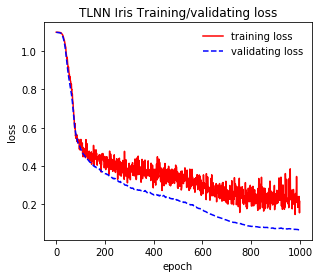

In [12]:
#----------------------------------------
# Summarize history for loss.

plt.ion()

plt.figure('TLNN Iris loss', figsize = (4.8, 4.0))
plt.plot(history.history['loss'], "r-")
plt.plot(history.history['val_loss'], "b--")
plt.title('TLNN Iris Training/validating loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validating loss'], loc = "best", frameon = False)


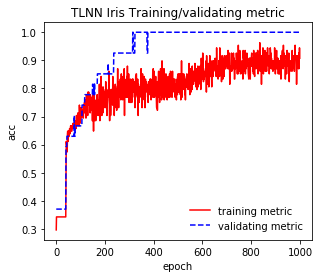

In [13]:
#----------------------------------------
# Summarize history for metric.

plt.figure('TLNN Iris metric', figsize = (4.8, 4.0))
plt.plot(history.history['acc'], "r-")
plt.plot(history.history['val_acc'], "b--")
plt.title('TLNN Iris Training/validating metric')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['training metric', 'validating metric'], loc = "best", frameon = False)
